# Libraries

In [43]:
import numpy as np
import sympy as sp
import sympy.physics.quantum as sq
import sympy.physics.quantum.qubit as sqq
import sympy.physics.quantum.gate as sqg

import cvxpy as cp

import matplotlib.pyplot as plt
import networkx as nx

sp.init_printing(use_latex='mathjax')
from IPython.display import display
from random import random
from random import seed

import pickle
import dill
dill.settings['recurse'] = True


#for pretty printing of matrices
import pandas as pd

import os


import multiprocessing as mp
from multiprocessing import Manager

## idealFid

In [44]:
class idealFid:
    
    def __init__(s):
        P1 = s.proj(1,5)
        P2 = s.proj(2,5)
        P3 = s.proj(3,5)
        P4 = s.proj(4,5)
        P5 = s.proj(5,5)
        s.P = [P1,P2,P3,P4,P5]
        s.terms = 5

    def proj(s,j,n):
        pi=np.pi
        temp1 = np.cos(pi/n)/(1+np.cos(pi/n))
        temp2 = 1-temp1
        temp3 = j*pi*(n-1)/n
        vec = np.asarray([np.sqrt(temp1),np.sqrt(temp2)*np.sin(temp3), np.sqrt(temp2)*np.cos(temp3)])
        mat = np.outer(vec,vec)
        return mat
    
    
    def idealVal(s,projList):
        op = s.P[projList[0]]
        for iProj in projList[1:]:
            op = op@s.P[iProj]
        return op[0,0]
    

## Extending braket functionality to include orthogonality

In [45]:
class onStruct:
    G = nx.Graph()

class onKet(sq.Ket,onStruct):
    def _eval_innerproduct(self,bra,**hints):
        #Check if the innerproduct is with yourself, then set 1
        if sq.Dagger(bra) == self:
            return sp.Integer(1)
        #Else, if the innerproduct is with a neighbor from the graph, set 0
        elif sq.Dagger(bra) in G[self]:
            return sp.Integer(0)
        #Else, do nothing; not enough information
    
    @classmethod
    def set_on_rel(cls,givenG):
        cls.G=givenG
    
    @classmethod
    def dual_class(self):
        return onBra

    
class onBra(sq.Bra,onStruct):
    @classmethod
    def dual_class(self):
        return onKet

In [46]:
class bKet(sq.Ket):
    
    #total number of kets (automatically increases as new instances are initialised)
    totalKets=0
    
    #this method automates the increase
    @classmethod
    def _eval_args(cls,args):
        #validate input type
        if not isinstance(args[0],int):
            raise ValueError("Integer expected in the argument, got: %r"%args[0])

        #if a ket |5> is initialised, the dimension is assumed to be 6 since we have |0>,|1>,...|5>
        if int(args[0])+1 > cls.totalKets:
            cls.totalKets=args[0]+1
        
        #pass control back to the base class
        return sq.Ket._eval_args(args) 
    
    #Could not find a way of using just one function; need to go through the two
    #based on a combination of the qubit implementation and the 
    def _represent_default_basis(s,**options):
        return s._represent_bKet(None,**options) #syntax taken from the Qubit library
    
    def _represent_bKet(s,basis,**options): #_represent_default_basis
        a=np.zeros(s.__class__.totalKets,dtype=int)
        a[s.label[0]]=1
        return sp.Matrix(a)
    
    @classmethod
    def set_dimension(cls,arg):
        cls.totalKets=arg
    
    def _eval_innerproduct(self,bra,**hints):
        #Check if the innerproduct is with yourself, then set 1
        if sq.Dagger(bra) == self:
            return sp.Integer(1)
        #Else, if the innerproduct is with a neighbor from the graph, set 0
        else:
            return sp.Integer(0)
        #Else, do nothing; not enough information
    

    @classmethod
    def dual_class(self):
        return bBra

    
class bBra(sq.Bra):
    # @classmethod
    # def _eval_args(cls,args):
    #     return args
    
    @classmethod
    def dual_class(cls):
        return bKet

## Extending tensor product functionality — tdsimp and tsimp

In [47]:

def powerDrop(expr):
    if isinstance(expr,sp.Pow): #TODO: make sure the base is not too complex
        # print("PowerEncountered")
        if expr.exp>=2:
            # print("glaba")
            # display(expr.base)
            _=sq.qapply(sp.Mul(expr.base,expr.base))
            if expr.exp>2:
                return powerDrop(_*sp.Pow(expr.base,expr.exp-2))
            else:
                return _
        else:
            return expr #autoDropDim(sp.Mul(expr.base,expr.base))
    else:
        if expr.has(sp.Pow):
            #if it is a sum or a product, run this function for each part and then combine the parts; return the result
            if isinstance(expr,sp.Mul) or isinstance(expr,sp.Add) or isinstance(expr,sq.TensorProduct):
                new_args=[] #list(expr.args)
                for _ in expr.args:
                    new_args.append(powerDrop(_))
                if isinstance(expr,sp.Mul):        
                    return sp.Mul(*new_args)
                elif isinstance(expr,sp.Add):
                    return sp.Add(*new_args)  
                elif isinstance(expr,sq.TensorProduct):
                    return sq.TensorProduct(*new_args)  

            else:
                return expr
            #There would be no else here because tensor product simp would have removed that part
        else:
            return expr        
    
def autoDropDim(expr):
    #print("Expression")
    #if isinstance(expr,sp.Mul):
        #print("type:multiplier")
    #display(expr)
    
    
    if isinstance(expr,sq.TensorProduct):
        new_args=[]
        for _ in expr.args:
            #display(_)
            #print(type(_))
            if _ != sp.Integer(1):
            #if not isinstance(_,core.numbers.One):
                new_args.append(_)
        #print("TensorProduct with %d non-ones in the tensor product"%len(new_args))
        if(len(new_args)==0):
            return sp.Integer(1)
        else:
            return sq.TensorProduct(*new_args)
    else:
        if expr.has(sq.TensorProduct):
            #if it is a sum or a product, run this function for each part and then combine the parts; return the result
            if isinstance(expr,sp.Mul) or isinstance(expr,sp.Add):
                new_args=[] #list(expr.args)
                for _ in expr.args:
                    new_args.append(autoDropDim(_))
                if isinstance(expr,sp.Mul):        
                    return sp.Mul(*new_args)
                elif isinstance(expr,sp.Add):
                    return sp.Add(*new_args)  
                
            #There would be no else here because tensor product simp would have removed that part
        else:
            return expr #when the expression is just an integer or some such


        
def tsimp(e,pruneMe=True):
    res=sq.qapply(powerDrop(sq.tensorproduct.tensor_product_simp(sq.qapply(e)).doit()))
    if pruneMe:
        return prune(res)
    else:
        return res

def tdsimp(e,pruneMe=True):
    res=autoDropDim(sq.qapply(powerDrop(autoDropDim(sq.tensorproduct.tensor_product_simp(sq.qapply(e)).doit()))))
    if pruneMe:
        return prune(res)
    else:
        return res
    #return autoDropDim(sq.tensorproduct.tensor_product_simp_Mul(e).doit())
    #return autoDropDim(sq.tensorproduct.tensor_product_simp_Mul(sq.qapply(e)).doit())
    #return autoDropDim(sq.tensorproduct.tensor_product_simp(e).doit())

## FindCoeff was unreliable

In [48]:
# depth=0
# depthThresh=20

def findCoeff(obj,lett):
#     global depth
    
#     print("Parent object:")
#     display(obj)
    
    if(obj==None):
#         print("coefficent is zero")
        return 0
    elif not (isinstance(obj,sp.Mul) or isinstance(obj,sp.Add)):        
        #the coefficient may be one but we couldn't see it earlier
        return obj.coeff(lett)
    else:
        #try to find the coefficient directly        
        result=obj.coeff(lett)
        #Did not work? 
        if(result==0):
            #try for each segment
            for _ in obj.args:
#                 print("child:")
#                 display(_)
                result=_.coeff(lett)
#                 print("coefficient of child:",result)
                
                #still did not work?
                if(result==0):
                    #try recursing
                    result = findCoeff(_,lett)    
                
                #found? Stop searching
                if(result!=0):
                    break
                    #return result

        #return whatever was found | worked
        return result



## Prune

In [49]:
def prune(expr,thr=10,remNum=False):
    if isinstance(expr,sp.Number): 
        if remNum==False:
            if sp.Abs(expr)<10**(-thr):
                return sp.Integer(0)
            else:
                return expr
        else:
            return sp.Integer(1)
    else:
        if expr.has(sp.Number):
            #if it is a sum or a product, run this function for each part and then combine the parts; return the result
            if isinstance(expr,sp.Mul) or isinstance(expr,sp.Add) or isinstance(expr,sq.TensorProduct):
                new_args=[] #list(expr.args)
                for _ in expr.args:
                    new_args.append(prune(_,thr,remNum))
                if isinstance(expr,sp.Mul):        
                    return sp.Mul(*new_args)
                elif isinstance(expr,sp.Add):
                    return sp.Add(*new_args)  
                elif isinstance(expr,sq.TensorProduct):
                    return sq.TensorProduct(*new_args)  

            else:
                return expr
            #There would be no else here because tensor product simp would have removed that part
        else:
            return expr        

# test=(A[0]*2)
# test.has(sp.Number)
# prune(test,remNum=True)

## Power to mul

In [50]:
# From: https://stackoverflow.com/questions/28117770/sympy-multiplications-of-exponential-rather-than-exponential-of-sum
# Thankfully I didn't have to sit and write this!

def pow_to_mul_(expr):
    """
    Convert integer powers in an expression to Muls, like a**2 => a*a.
    """
    pows = list(expr.atoms(sp.Pow))
    if any(not e.is_Integer for b, e in (i.as_base_exp() for i in pows)):

        raise ValueError("A power contains a non-integer exponent")
    repl = zip(pows, (sp.Mul(*[b]*e,evaluate=False) for b,e in (i.as_base_exp() for i in pows)))
    return expr.subs(repl)

In [51]:
## Not very well written

def pow_to_mul(expr):
    if isinstance(expr,sp.Pow): 
        return pow_to_mul_(expr)
    else:
        try:
            if expr.has(sp.Pow):
                #if it is a sum or a product, run this function for each part and then combine the parts; return the result
                if isinstance(expr,sp.Mul) or isinstance(expr,sp.Add):
                    new_args=[] #list(expr.args)
                    for _ in expr.args:
                        new_args.append(pow_to_mul(_))

                    if isinstance(expr,sp.Mul):        
                        return sp.Mul(*new_args,evaluate=False)
                    elif isinstance(expr,sp.Add):
                        return sp.Add(*new_args)
                else:
                    return expr
            else:
                return expr      
        except:
            return expr

In [52]:
def mul_to_single_mul(expr):
    if isinstance(expr,sp.Mul): 
        new_args=[]
        for _ in expr.args:
            if isinstance(_,sp.Mul):
                for __ in _.args:
                    new_args.append(__)
            elif expr.has(sp.Mul):
                new_args.append(mul_to_single_mul(_)) #If inside a mul, there is another mul, extract it
            else:
                new_args.append(_)  #if it is something entirely different, bring it along as it is
        
        return sp.Mul(*new_args,evaluate=False) #put the new arguments into a single multiply and return
    
    else:
        try:
            if expr.has(sp.Mul):
                #if it is a sum, run this function for each part and then combine the parts; return the result
                if isinstance(expr,sp.Add):
                    new_args=[] #list(expr.args)
                    for _ in expr.args:
                        new_args.append(mul_to_single_mul(_))
                    if isinstance(expr,sp.Add):
                        return sp.Add(*new_args)
                else:
                    return expr
            else:
                return expr      
        except:
            return expr

In [53]:
def pow_to_single_mul(expr):
    return mul_to_single_mul(pow_to_mul(expr))

## Reverse

In [54]:

def rev(expr):
    if isinstance(expr,sp.Mul):
        newargs=list(expr.args)
        newargs.reverse()
        return sp.Mul(*newargs)
    else:
        if expr.has(sp.Mul):
            #if it is a sum  run this function for each part and then combine the parts; return the result
            if isinstance(expr,sp.Add):
                new_args=[] #list(expr.args)
                for _ in expr.args:
                    new_args.append(rev(_))                
                return sp.Add(*new_args)
            else:
                return expr
            #There would be no else here because tensor product simp would have removed that part
        else:
            return expr     

## Stochastic/Pretty Printing (prints a random subset)

In [55]:
stRandVal=1   
    
def stRand():
    global stRandVal
    stRandVal=random()

def stPrint(s):
    global stRandVal
    if(gls['printVerbose'] and stRandVal <= gls['printSparsity']):    
        print(s)
    
def stDisplay(s):
    global stRandVal
    if(gls['printVerbose'] and stRandVal <= gls['printSparsity']):    
        display(s)

In [56]:
def prettyX(X):
    global L
    X_=np.zeros((len(L),len(L)))
    i=0
    j=0
    for l1 in L:
        for l2 in L:
            X_[i][j]=X[sTr[l1]][sTc[l2]].value
            j+=1
        j=0
        i+=1
    return X_


def prettyPrint(X):
    try:
        y=pd.DataFrame(prettyX(X))
    except:
        y=pd.DataFrame(X)
    #print(y)
    display(y)

# Global Settings

In [57]:
#This produces repeatable sparse prints
#uncomment to make them stochastic
seed(1)

## helps auto generation of the ideal observations
def lovasz(n):
    return (n*(np.cos(np.pi/n))/(1+np.cos(np.pi/n)))

gls = {}

gls['testType'] = 0
# 0 means no test; the real thing
# 1 is the KCBS objective; with neither observations nor the localising matrix constraints
# 2 means construct F for only the state
# 3 means ...
# 4 is feasibility testing; objective zero

#why do i have single variables in Lx?

gls['testSubType'] = "a" #"e" #"d" #"a2"
#For number 1:
#a (or any other not listed): KCBS objective
#b: adds observed constraints
#c: tests localising matrices with a translation operator based objective
#d: tests just the translation operator based objective (without localising matrices that is)
#e: KCBS from expression + twist
#a2: KCBS explicitly written with twist
#f: trace (tested with this)
#ks: Kishor Sucks! Testing the translate operator; hard coded

gls['threads'] = 40
gls['threadsQM'] = 10

gls['hDepth'] = 3 #depth of the heirarchy; depends on the number of Πs in the expression for Fidelity; 3 needed

gls['locMatDepth'] = 2 #number of letters to consider for constructing the localising matrix

gls['usePs'] = True #enables the localising matrix setup; if this is disabled, hDepth would have to be around 6
#if this is enabled, hDepth can be 3 and it still runs fine

gls['cacheFolder'] = "cached/"

gls['N']=5

gls['cacheFolderN'] = gls['cacheFolder'] + "with"+ str(gls['N'])


gls['obsData'] = [np.cos(np.pi / gls['N']) / (1 + np.cos(np.pi / gls['N'])) for i in range(gls['N']) ]

gls['solverSettings'] = {'verbose':True,'solver':cp.SCS,'max_iters':16*2500,'warm_start':True}

# gls['solverSettings'] = {'verbose':True,'solver':cp.SCS,'max_iters':2500,'warm_start':True}

def globalSettings(newGls):
    global gls
    
    #sanity check
    #[*gls] creates a list of keys
    #set converts a list into a set
    
    setKeysOriginal=set([*gls])
    setKeysNew=set([*newGls])
    
    if(setKeysNew<=setKeysOriginal):
        gls.update(newGls)
        gls['cacheFolderN']=gls['cacheFolder']+ "with" + str(gls['N'])
        gls['obsData']=[lovasz(gls['N'])/gls['N']]*gls['N']
    else:
        print("Unknown setting:",setKeysNew-setKeysOriginal)        
        print("Current settings are:",gls)


In [ ]:
#globalSettings({'testTypea':7})
# print(gls)

# Ideal KCBS

## The class

In [58]:

class cls_iKCBS:    
    
    def __init__(s,n,verbose=False,thr=10,test=False,forceCalc=False):
        print("The testType is", gls['testType'])
        s.thr=thr
        if verbose==True:
            print("Creating projectors etc")

        cls_iKCBS.n=n
        #j in 0,1,2,3,4
        
        s.ke = [bKet(j) for j in range(3)]    
        s.br = [sq.Dagger(s.ke[j]) for j in range(3)]
        
        s.Πs = []
                
        ### N'd here
        #evaluate the projectors for the ideal case
        for j in range(n):
            s.Πs.append(sp.N(s.eval(j,n)))

        if(test and False):
            print("Testing Πs")
            for i in range(n):
                for k in range(n):
                    print("Inner product of ",i," and ",k," projectors is")
                    temp=0
                    for j in range(3):
                        temp+=sq.qapply(s.br[j]*s.Πs[i]*s.Πs[k]*s.ke[j])
                    print(temp)
                    del temp
                    
   
        #calculate the matrix representation
        s.matΠs = [sq.represent(_) for _ in s.Πs] #I leave this as well to avoid breaking things; TODO: try to remove it
        
        ### N'd here
        #the first two vectors are taken to be k'
        s.kp = [sp.N(s.eval(0,n,True)),sp.N(s.eval(1,n,True))]
        
        #the third is constructed as k0 x k1 (cross product) and then added to the list
        s.kp.append(sp.N(s.cross(s.kp)))
        
        
        #evaluates the conjugate for each element in the list
        s.bp=[sq.Dagger(ikp) for ikp in s.kp]                
        
        if(test):
            #Testing orthogonality
            print("Testing orthogonality of the braP and ketP objects")
            for braP in s.bp:
                for ketP in s.kp:
                    print(sq.qapply(braP*ketP))#sp.N(sq.qapply(braP*ketP)))
        
    
        #the Translation operator
        s.T = s.kp[0]*s.bp[2] + s.kp[1]*s.bp[0] + s.kp[2]*s.bp[1] 
        s.Ti = s.kp[2]*s.bp[0] + s.kp[0]*s.bp[1] + s.kp[1]*s.bp[2] #TODO: Automate this
        
        if(test):
            print("Testing the basic Translation operator")
            for braP in s.bp:
                for ketP in s.kp:
                    #print(braP)
                    print(sq.qapply(braP*s.T*ketP))#sp.N(sq.qapply(braP*ketP)))
                    #print(sp.N(sq.qapply(sp.N(braP)*sp.N(s.T)*sp.N(ketP))))
            display(sq.represent(s.T))

        
        #s.mT = s.mkp[0]*s.mbp[2] + s.mkp[1]*s.mbp[0] + s.mkp[2]*s.mbp[1] 
        #s.mTi = s.mkp[2]*s.mbp[0] + s.mkp[0]*s.mbp[1] + s.mkp[1]*s.mbp[2] #TODO: Automate this
        
        s.matT=sq.represent(s.T)
        
        # print("matT:")
        # print(s.matT)
        
        #Now the abstract ones
        
        #creates n abstract projectors (basically just a bunch of non-commuting symbols)
        s._Πs = sp.symbols('Π_0:%d'%n,commutative=False)
        
        #We use this to create a localising matrix
        #We must imposes conj(_P) * Translation >> 0
        s._P = sp.symbols('P',commutative=False) 
        s._Pd = sp.symbols('Pd',commutative=False) #we define them separately because sq.dagger doesn't work too well with symbols which are not based on kets etc
        #s._Pd = sq.dagger(sp)
        
        s.daggerDict = {}
        s.sqDict = {}
        for i in range(n):
            s.daggerDict[sq.Dagger(s._Πs[i])]=s._Πs[i]
            s.sqDict[(s._Πs[i])*(s._Πs[i])]=s._Πs[i]
        
        s.daggerDict[sq.Dagger(s._Pd)]=s._P
        s.daggerDict[sq.Dagger(s._P)]=s._Pd
        s.sqDict[s._P*s._Pd]=sp.Integer(1)
        s.sqDict[s._Pd*s._P]=sp.Integer(1)
        
        #not very happy because it should come from the graph
        s.gDict = {}
        for i in range(n):
            s.gDict[s._Πs[i]*s._Πs[(i+1)%n]]=sp.Integer(0)
            s.gDict[s._Πs[(i+1)%n]*s._Πs[i]]=sp.Integer(0)
        
        if verbose==True:
            print("Solving a linear system to find the coefficients for expressing the translation operator as a sum of projectors")

        s._T=s.eval_lin_c() #NB: it computes the coefficients into s.c    
        
        ##Debugging
        s.numTDict={}
        for i in range(n):
            s.numTDict[s._Πs[i]]=s.Πs[i]
        if(test):
            print("Converting the numerical solution into a usable form")
            #display(s._T)
            numT = s._T.subs(s.numTDict)
            #display(numT)
            print("Testing the numerically found Translation operator.")
            # for braP in s.bp:
            #     for ketP in s.kp:
            #         print(sq.qapply(braP*numT*ketP)) #sp.N(sq.qapply(braP*ketP)))
            numMatT=sq.represent(numT)
            display(sp.Transpose(numMatT) * numMatT)
            
            display(sq.represent(numT))
            

        if verbose==True:
            print("Solving the cross Π")
        
        # print("The cross is")
        # print(sq.represent(s.kp[2]*s.bp[2]))
        # print("|0'⟩")
        # print(sq.represent(s.kp[0]))
        # print("|1'⟩")
        # print(sq.represent(s.kp[1]))
        # print("|2'⟩")
        # print(sq.represent(s.kp[2]))
        
        # for i in range(3):
        #     for j in range(3):
        #         print("innerproduct:", i,j)
        #         print(sq.represent(s.bp[i]*s.kp[j]))
        # for i in range(5):
        #     print("ideal vec",i)
        #     print(sq.represent(sp.N(s.eval(i,n,True))))
        
        #s._Πcross = s.eval_Π_cross(RHS=sq.represent(s.kp[2]*s.bp[2])) #s.eval_lin_c(RHS=sq.represent(s.kp[2]*s.bp[2]))
        
        s._Πcross = s.eval_lin_c(RHS=sq.represent(s.kp[2]*s.bp[2]))
            
        if verbose==True:
            print("Evaluating F")

        if(test):
            s.Πcross = s.eval_lin_c(RHS=sq.represent(s.kp[2]*s.bp[2]),retIde=True)
            s.test_swapGate()
            
        if(not test):
            
            filename=gls['cacheFolderN']+"Fsaved4_loc"+str(gls['usePs'])
            if(gls['testType']==2):
                filename+="_stateOnly"
            
            try:
                y=dill.load(open(filename,"rb"))
                # if(gls['testType']==2):
                #     y=dill.load(open("Fsaved3_stateOnly", "rb"))
                # else:
                #     y=dill.load(open("Fsaved3", "rb"))
                s.F=y
                print("Loaded from file")
            except:
                y=None
            
            if (y==None or forceCalc==True): 
                if (gls['testType']==0 or gls['testType']==2):
                    print("Evaluating F")
                    s.eval_state_hw()
                    s.Fs = [s.eval_state_F()]    
                    if(gls['testType']!=2):
                        for i in range(n):
                            print("iteration: ",i)
                            s.Fs.append(s.Fs[-1]+5.0*s.eval_state_F(s.Πs[i],s._Πs[i]))
                    #s.F = s.Fs[-1] #last element, the most recent calculation
                    s.F = prune(s.Fs[-1])
                    # if(gls['testType']==2):
                    #     dill.dump(s.F, open("Fsaved3_stateOnly", "wb"))
                    # else:
                    #     dill.dump(s.F, open("Fsaved3", "wb"))
                    dill.dump(s.F,open(filename,"wb"))
                    print("Saved to disk")
                else:

                    print("Dummy F")
                    s.F = 0
        
        print("done")
        
    def eval_idealVal(s,expr):
        value = 0
        try:
            value = sq.represent(expr.subs(s.numTDict))[0,0] #sq.represent(s.br[0])@sq.represent(expr.subs(s.numTDict))@sq.represent(s.ke[0])[0][0]
        except:
            value = sq.represent(expr.subs(s.numTDict)) #if a number was the expression
        
        return value
        
    def test_swapGate(s):
        s.TP = sq.TensorProduct 
        s.T = s.kp[0]*s.bp[2] + s.kp[1]*s.bp[0] + s.kp[2]*s.bp[1] 
        s.Ti = s.kp[2]*s.bp[0] + s.kp[0]*s.bp[1] + s.kp[1]*s.bp[2] #TODO: Automate this
        
        Id_ = s.kp[0]*s.bp[0] + s.kp[1]*s.bp[1] + s.kp[2]*s.bp[2]
        
        dontDie=prune(sp.N(sq.qapply(s.T*s.T)))
        
        _U_=sq.represent(s.TP(Id_,s.kp[0]*s.bp[0])) + sq.represent(s.TP(s.T,s.kp[1]*s.bp[1])) \
        + sq.represent(s.TP(dontDie,s.kp[2]*s.bp[2]))
        display(_U_)
        
        _T_=sq.represent(s.TP(Id_,s.kp[0]*s.bp[0] + s.kp[2]*s.bp[1] + s.kp[1]*s.bp[2]))
        display(_T_)        
        
        #_V_= sq.represent(s.TP(s.kp[0]*s.bp[0],Id_) + s.TP(s.kp[1]*s.bp[1],s.Ti) + s.TP(s.kp[2]*s.bp[2],s.Ti*sp.N(s.Ti)))
        _V_ = sq.represent(s.TP(s.Πs[0],Id_) + s.TP(s.Πs[1],s.Ti) + s.TP(s.Πcross,s.Ti*sp.N(s.Ti)))
        display(_V_)
        
        print("comparing the projectors with the ket based projectors")
        
        display(sq.represent(s.kp[0]*s.bp[0]))
        display(sq.represent(s.Πs[0]))

        display(sq.represent(s.kp[1]*s.bp[1]))
        display(sq.represent(s.Πs[1]))

        display(sq.represent(s.kp[2]*s.bp[2]))
        display(sq.represent(s.Πcross))
        
        print("did this work?")
        
        
        SWAP = _T_*_U_*_V_*_U_
        display(SWAP)
        
        testVec=sq.represent(s.TP(s.ke[0],s.ke[1]))
        print("Multiplying this")
        display(testVec)
        display(SWAP*testVec)
        
    def eval_state_hw(s):
        s.TP = sq.TensorProduct
        #Perhaps this should be P and not Pd
        
        if(gls['usePs']):
            #s._U_=tsimp(s.TP(sp.Integer(1),prune(sp.N(s.kp[0]*s.bp[0]))) + s.TP(s._Pd,prune(sp.N(s.kp[1]*s.bp[1]))) + s.TP(s._Pd * s._Pd,prune(sp.N(s.kp[2]*s.bp[2]))))
            s._U_=tsimp(s.TP(sp.Integer(1),prune(sp.N(s.kp[0]*s.bp[0]))) + \
                        s.TP(s._P,prune(sp.N(s.kp[1]*s.bp[1]))) + \
                        s.TP(s._P * s._P,prune(sp.N(s.kp[2]*s.bp[2]))))
        else:            
            dontDie=prune(sp.N(sq.qapply(s._T*s._T)))
            s._U_=tsimp(s.TP(sp.Integer(1),prune(sp.N(s.kp[0]*s.bp[0]))) + \
                        s.TP(s._T,prune(sp.N(s.kp[1]*s.bp[1]))) + \
                        s.TP(dontDie,prune(sp.N(s.kp[2]*s.bp[2]))))
            
        s._T_=s.TP(sp.Integer(1),prune(sp.N(s.kp[0]*s.bp[0])) + prune(sp.N(s.kp[2]*s.bp[1])) + prune(sp.N(s.kp[1]*s.bp[2])))
        s._V_=prune(s.TP(s._Πs[0],sp.Integer(1)) + s.TP(s._Πs[1],prune(sp.N(s.Ti))) + s.TP(prune(s._Πcross),prune(sp.N(s.Ti)*sp.N(s.Ti))))
        
    
    def eval_state_F(s,proj=sp.Integer(1),proj_=sp.Integer(1)):
        s.TP = sq.TensorProduct #just to make naming easy
            

        print("Evaluated U,T,V; staying alive")

        _kin_ = s.TP(sp.Integer(1),sp.N(sq.qapply(proj*s.ke[0])))
        _bin_ = s.TP(sp.Integer(1),sp.N(sq.qapply(s.br[0]*proj)))
        
        
        _kout_ = s.TP(sp.Integer(1)*proj_,sp.N(s.kp[0])) #s.TP(sp.Integer(1),sp.N(s.kp[0]))
        _bout_ = s.TP(sp.Integer(1)*proj_,sp.N(s.bp[0])) #s.TP(sp.Integer(1),sp.N(s.bp[0]))
                                                                                             

        print("evaluation stage:")
        F0=tsimp(_bin_ * s._T_).subs(s.gDict)
        print("1")
        F1=tsimp(F0 * s._U_).subs(s.gDict) #*_V_
        print("2")
        # #s.F2=tsimp(F1 * _V_)
        # #G00 = tsimp(F1*_V_)
        # #print("2.1")
        # #display(_U_)
        # G00 = tsimp(_U_*_kout_).subs(s.gDict)
        # print("2.1")
        # G01 = tsimp(_V_*G00).subs(s.gDict)
        # print("2.2")
        # #G0 = tsimp(_V_*_U_)
        # t1=sq.qapply(F1*G01).subs(s.gDict)
        # print("2.3")
        
        G0=tsimp(s._V_*_kout_).subs(s.gDict)
        print("3")
        
        #display(F1)
        #display(G0)
        t1=sq.qapply(F1*G0).subs(s.gDict)
        
        t2=t1.subs(s.daggerDict).subs(s.sqDict) #not sure why the s.daggerDict step is needed;
        
        H0 = tsimp(t2) #tsimp(F1*G0)
        print("4")
        #s.F1 = s._bout_ * _T_ * _U_ * _V_ * s._kout_
        #s.F2 = s.F1 * 
        s.F = tdsimp(H0)
        print("5")
        
        #return tdsimp(sp.expand(s.F * sq.Dagger(s.F)))
        return sp.expand((sq.Dagger(s.F) * s.F).subs(s.daggerDict)).subs(s.sqDict).subs(s.sqDict).subs(s.gDict)
        if verbose==True:
            print("Dinner out is a go.")
        
    def cross(s,vecs):
        ca=[sq.qapply(sq.Dagger(s.ke[i])*vecs[0]).doit() for i in range(3)]
        cb=[sq.qapply(sq.Dagger(s.ke[i])*vecs[1]).doit() for i in range(3)]
        
        res = (ca[2-1]*cb[3-1] - ca[3-1]*cb[2-1])*s.ke[0] + \
             (ca[3-1]*cb[1-1]-ca[1-1]*cb[3-1])*s.ke[1] + \
             (ca[1-1]*cb[2-1] - ca[2-1]*cb[1-1])*s.ke[2]
        
        return res

    
    #This I may not even be using
    #I had made eval_lin_c more capable
    def eval_Π_cross(s,RHS,varCount=None):
        cls=s.__class__
        if varCount==None:
            varCount=cls_iKCBS.n*2
        if varCount <= cls.n:
            raise ValueError("number of variables should be at least n")
    
        #a=sp.symbols('a0:%d'%varCount)
        varCount=9
        a=sp.symbols('a0:%d'%9)
        ap=[]
        #s.b=sp.symbols('b0:%d'%varCount)
        b=[] #family of solutions
        s.c=[] #particular solution with the free variables set to one
        
        #Setting up of constraints
        #If the system is not able to find a solution, consider increasing
        #the number of variables by taking different sets of products or products of three operators
        
        TfΠ = [a[0]*s.Πs[0] + a[1]*s.Πs[1] + a[2]*s.Πs[2] + a[3]*s.Πs[3] + a[4]*s.Πs[4] + \
                     a[5]*s.Πs[4]*s.Πs[2] + \
                     a[6]*s.Πs[4]*s.Πs[1] + \
                     a[7]*s.Πs[1]*s.Πs[3] + \
                     a[8]*s.Πs[2]*s.Πs[0] ]
        
        _TfΠ = [a[0]*s._Πs[0] + a[1]*s._Πs[1] + a[2]*s._Πs[2] + a[3]*s._Πs[3] + a[4]*s._Πs[4] + \
                     a[5]*s._Πs[4]*s._Πs[2] + \
                     a[6]*s._Πs[4]*s._Πs[1] + \
                     a[7]*s._Πs[1]*s._Πs[3] + \
                     a[8]*s._Πs[2]*s._Πs[0] ]        
        
#         TfΠ=[a[0]*s.Πs[0]]
#         _TfΠ=[a[0]*s._Πs[0]]
#         ap.append(a[0])
#         for i in range(1 +cls.n):
#             #if (not (i==2 or i==3)):
#             TfΠ.append(TfΠ[-1] + a[i]*s.Πs[i])
#             _TfΠ.append(_TfΠ[-1] + a[i]*s._Πs[i])
#             ap.append(a[i])            

#         if cls.n == 5:
#             TfΠ.append(TfΠ[-1] + a[5]*s.Πs[4]*s.Πs[2] \
#                     + a[6]*s.Πs[4]*s.Πs[1] \
#                     + a[7]*s.Πs[1]*s.Πs[3] \
#                     + a[8]*s.Πs[2]*s.Πs[0])
#             _TfΠ.append(_TfΠ[-1] + a[5]*s._Πs[4]*s._Πs[2] \
#                     + a[6]*s._Πs[4]*s._Πs[1] \
#                     + a[7]*s._Πs[1]*s._Πs[3] \
#                     + a[8]*s._Πs[2]*s._Πs[0])
#             ap+=[a[5],a[6],a[7],a[8]]

        LHS=sq.represent(TfΠ[-1])
        #display(_TfΠ)
        # LHS=a[0]*s.matΠs[0]
        # for i in range(1,cls.n):
        #     LHS=LHS+a[i]*s.matΠs[i]
        # for i in range(cls.n,varCount):
        #     LHS=LHS+a[i]*s.matΠs[i%cls.n]*s.matΠs[(i+2)%cls.n]
            
        #RHS=s.matT
        
        if cls.n!=5:
            soln=sp.solve(sp.N(LHS-RHS),a,dict=True)
        else:
            soln=sp.solve(sp.N(LHS-RHS),a[:9],dict=True)
            #soln=sp.solve(sp.N(LHS-RHS),ap,dict=True)
        
        print(soln)
        #print("type:",type(soln[0]))#, " and shape:", soln.shape())
        for key,value in soln[0].items():
            if np.abs(value)<10**(-s.thr):
                soln[0][key]=sp.Integer(0)
        
        print(soln)
        '''
            #soln=sp.solve([a[0]-1,a[1]-2,a[2]-3,a[3]-4,a[4]-5,a[5]-1,a[6]-1,a[7]-1,a[8]-1,a[9]-1],a,dict=True)

            # sols = solve([t1 + t2 + t3, eq1, eq2], [t1, t2, t3], dict=True)
            # sols[0][t1] # This is t1 in the first solution        
        '''

        #Dictionary to assign one/zero to free variables
        dRem={}
        
        #IMPORTANT: 
        #In sympy, symbols/expressions are unmutable (you can't change them ever);
        #You can save a substituted expression into a new expression (and use a symbol to denote it)
        #To wit: when you substitute, a new expression is produced

        for i in range(varCount):
            #the variables which were evaluated to an expression, assign them to b[i]
            try:
                b.append(soln[0][a[i]])      
            #if the variable was free, assign b[i] to be one
            #and create a dictionary to substitute these free variables
            except:
                b.append(sp.Integer(1))
                dRem[a[i]]=1
        
        #in the solution saved into b[i], substitute for the free variables using the dictionary
        #save the result into the variable c
        s.c = [_.subs(dRem) for _ in b]

        #substitute the solution into the coefficients in Tfπ_p, the operator T as a sum of projectors (and its products)
        dFin={}
        for i in range(varCount):
            dFin[a[i]]=s.c[i]                
        
        return _TfΠ[-1].subs(dFin)            
        
    
    #evaluates the matrices and vectors
    def eval(s,j,n,ve=False):
        N=sp.Integer(n)
        J=sp.Integer(j+1)
        #print(N,j)
        one=sp.Integer(1)
        #print(one)
        α1=sp.cos((sp.pi)/N)/(one+sp.cos(sp.pi/N)) #verified
        #a1=sp.cos(sp.pi/N)
        #
        #print(α1)
        
        α2=one-α1 #verified
        α3=J * sp.pi * (N-one)/N #verified
        
        vec = sp.sqrt(α1)*s.ke[0] + sp.sqrt(α2)*sp.sin(α3)*s.ke[1] + sp.sqrt(α2)*sp.cos(α3)*s.ke[2]
        
        projector = vec*sq.Dagger(vec)
           
        #matrixprojector = sp.Matrix([0,0])
        #return projector
        #display(sq.represent(projector))
        #display(sq.represent(vec))
        
        if ve==False:
            return projector
        else:
            return vec
    
    
    #I use this for both the projector
    #and for the cross product
    
    def eval_lin_c(s,varCount=None,RHS=None,retIde=False):
        cls=s.__class__
        if varCount==None:
            varCount=cls_iKCBS.n*2
        if varCount <= cls.n:
            raise ValueError("number of variables should be at least n")
    
        a=sp.symbols('a0:%d'%varCount)
        #s.b=sp.symbols('b0:%d'%varCount)
        b=[] #family of solutions
        s.c=[] #particular solution with the free variables set to one
        
        #Setting up of constraints
        #If the system is not able to find a solution, consider increasing
        #the number of variables by taking different sets of products or products of three operators
        TfΠ=[a[0]*s.Πs[0]]
        _TfΠ=[a[0]*s._Πs[0]]
        
        
        #if n is 5, then we use a special form (the general method doesn't find good solutions for some reason)
        if cls.n == 5:            
            for i in range(1,5):
                TfΠ.append(TfΠ[-1] + a[i]*s.Πs[i])
                _TfΠ.append(_TfΠ[-1] + a[i]*s._Πs[i])
            
            TfΠ.append(TfΠ[-1] + a[5]*s.Πs[4]*s.Πs[2] \
                    + a[6]*s.Πs[4]*s.Πs[1] \
                    + a[7]*s.Πs[1]*s.Πs[3] \
                    + a[8]*s.Πs[2]*s.Πs[0])
            _TfΠ.append(_TfΠ[-1] + a[5]*s._Πs[4]*s._Πs[2] \
                    + a[6]*s._Πs[4]*s._Πs[1] \
                    + a[7]*s._Πs[1]*s._Πs[3] \
                    + a[8]*s._Πs[2]*s._Πs[0])

            if RHS == None:
                RHS=s.matT
            
            LHS=sq.represent(TfΠ[-1])
            
            soln=sp.solve(sp.N(LHS-RHS),a[:9],dict=True)
        #if n is 7, then the form we use depends on whether we want the cross product solved or the translation operator solved
        #if it is the translation operator, then RHS is none
        elif cls.n == 7:
            for i in range(1,5):
                TfΠ.append(TfΠ[-1] + a[i]*s.Πs[i])
                _TfΠ.append(_TfΠ[-1] + a[i]*s._Πs[i])
            
            
            #x1*P1 + x2*P2 + x3*P3 + x4*P4 + x5*P5 + x6*(P5@P3) + x7*(P5@P2) + x8*(P2@P4) + x9*(P3@P1)
            #x5*(p4*p2) + x6*(p4*p1) + x7*(p1*p3) + x8(p2*p0)
            
            #Translation Op | the form is the same as that for n=5
            if RHS == None:
                TfΠ.append(TfΠ[-1] + a[5]*s.Πs[4]*s.Πs[2] \
                        + a[6]*s.Πs[4]*s.Πs[1] \
                        + a[7]*s.Πs[1]*s.Πs[3] \
                        + a[8]*s.Πs[2]*s.Πs[0])
                _TfΠ.append(_TfΠ[-1] + a[5]*s._Πs[4]*s._Πs[2] \
                        + a[6]*s._Πs[4]*s._Πs[1] \
                        + a[7]*s._Πs[1]*s._Πs[3] \
                        + a[8]*s._Πs[2]*s._Πs[0])

                RHS=s.matT
                print("Solving the Translation operator's solution hardcoded")

                LHS=sq.represent(TfΠ[-1])

                soln=sp.solve(sp.N(LHS-RHS),a[:9],dict=True)
                
                
            #For the Cross Operator | the form is now different    
            #term1 = x1*P1 + x2*P2 +x3*P3 + x4*P4 + x5*P5 + x6*P6
            #x0*p0 + x1*p1 + x2*p2 + x3*p3 + x4*p4 + x5*p5
            # term2 = x8*(P1@P3) + x9*(P3@P1) + x10*(P2@P4)
            #x7*p0*p2 + x8*p2*p0 + x9*p1*p3

            else:
                TfΠ.append(TfΠ[-1] + a[5]*s.Πs[5] \
                        +  a[7]*s.Πs[0]*s.Πs[2] \
                        +  a[8]*s.Πs[2]*s.Πs[0] \
                        +  a[9]*s.Πs[1]*s.Πs[3])
                _TfΠ.append(_TfΠ[-1] + a[5]*s._Πs[5] \
                        +  a[7]*s._Πs[0]*s._Πs[2] \
                        +  a[8]*s._Πs[2]*s._Πs[0] \
                        +  a[9]*s._Πs[1]*s._Πs[3])            

                LHS=sq.represent(TfΠ[-1])

                soln=sp.solve(sp.N(LHS-RHS),a[:10],dict=True)

        else:
            #in general we include a[0]*Π[0] + a[1]*Π[1] + .. a[n-1]*Π[n-1]
            for i in range(1,cls.n):
                TfΠ.append(TfΠ[-1] + a[i]*s.Πs[i])
                _TfΠ.append(_TfΠ[-1] + a[i]*s._Πs[i])
            
            for i in range(cls.n,varCount):
                TfΠ.append(TfΠ[-1] + a[i]*s.Πs[i%cls.n]*s.Πs[(i+2)%cls.n])
                _TfΠ.append(_TfΠ[-1] + a[i]*s._Πs[i%cls.n]*s._Πs[(i+2)%cls.n])
                
            if RHS == None:
                RHS=s.matT
            
            LHS=sq.represent(TfΠ[-1])
            
            soln=sp.solve(sp.N(LHS-RHS),a,dict=True)
            
        
            
            
#         LHS=sq.represent(TfΠ[-1])
#         #display(_TfΠ)
#         # LHS=a[0]*s.matΠs[0]
#         # for i in range(1,cls.n):
#         #     LHS=LHS+a[i]*s.matΠs[i]
#         # for i in range(cls.n,varCount):
#         #     LHS=LHS+a[i]*s.matΠs[i%cls.n]*s.matΠs[(i+2)%cls.n]
#         if RHS == None:
#             RHS=s.matT
        
#         if cls.n==5:
#             soln=sp.solve(sp.N(LHS-RHS),a[:9],dict=True)
#         else:
#             soln=sp.solve(sp.N(LHS-RHS),a,dict=True)
            
        
        
        
        
        print(soln)
        #print("type:",type(soln[0]))#, " and shape:", soln.shape())
        for key,value in soln[0].items():
            prune(value)
            soln[0][key]=value
            # print(value)
            # if np.abs(value)<10**(-s.thr):
            #     soln[0][key]=sp.Integer(0)
        
        print(soln)
        '''
            #soln=sp.solve([a[0]-1,a[1]-2,a[2]-3,a[3]-4,a[4]-5,a[5]-1,a[6]-1,a[7]-1,a[8]-1,a[9]-1],a,dict=True)

            # sols = solve([t1 + t2 + t3, eq1, eq2], [t1, t2, t3], dict=True)
            # sols[0][t1] # This is t1 in the first solution        
        '''

        #Dictionary to assign one/zero to free variables
        dRem={}
        
        #IMPORTANT: 
        #In sympy, symbols/expressions are unmutable (you can't change them ever);
        #You can save a substituted expression into a new expression (and use a symbol to denote it)
        #To wit: when you substitute, a new expression is produced

        for i in range(varCount):
            #the variables which were evaluated to an expression, assign them to b[i]
            try:
                b.append(soln[0][a[i]])      
            #if the variable was free, assign b[i] to be one
            #and create a dictionary to substitute these free variables
            except:
                b.append(sp.Integer(1))
                dRem[a[i]]=1
        
        # print("Substituting free variables for one")
        # print(b)
        
        #in the solution saved into b[i], substitute for the free variables using the dictionary
        #save the result into the variable c
        s.c = [_.subs(dRem) for _ in b]

        #substitute the solution into the coefficients in Tfπ_p, the operator T as a sum of projectors (and its products)
        dFin={}
        for i in range(varCount):
            dFin[a[i]]=s.c[i]                
        
        #soln[0].subs(dFin)
        print("final substitution")
        print(dFin)
        
        if retIde==False:
            return _TfΠ[-1].subs(dFin)
        else:
            return TfΠ[-1].subs(dFin)
            
    def eval_c(s,varCount=None):
        cls=s.__class__
        if varCount==None:
            varCount=cls_iKCBS.n*2
        if varCount <= cls.n:
            raise ValueError("number of variables should be at least n")
    
        a=sp.symbols('a0:%d'%varCount)
        #s.b=sp.symbols('b0:%d'%varCount)
        b=[] #family of solutions
        s.c=[] #particular solution with the free variables set to one
        
        #Setting up of constraints
        #If the system is not able to find a solution, consider increasing
        #the number of variables by taking different sets of products or products of three operators
        TfΠ=a[0]*s.Πs[0]
        _TfΠ=a[0]*s._Πs[0]
        for i in range(1,cls.n):
            TfΠ=TfΠ + a[i]*s.Πs[i]
            _TfΠ=_TfΠ + a[i]*s._Πs[i]
        for i in range(cls.n,varCount):
            TfΠ=TfΠ + a[i]*s.Πs[i%cls.n]*s.Πs[(i+2)%cls.n]
            _TfΠ=_TfΠ + a[i]*s._Πs[i%cls.n]*s._Πs[(i+2)%cls.n]
            
            
        LHS=sq.represent(TfΠ)
        
        # LHS=a[0]*s.matΠs[0]
        # for i in range(1,cls.n):
        #     LHS=LHS+a[i]*s.matΠs[i]
        # for i in range(cls.n,varCount):
        #     LHS=LHS+a[i]*s.matΠs[i%cls.n]*s.matΠs[(i+2)%cls.n]
            
        RHS=s.matT
        
        soln=sp.solve(sp.N(LHS-RHS),a,dict=True)

        '''
            #soln=sp.solve([a[0]-1,a[1]-2,a[2]-3,a[3]-4,a[4]-5,a[5]-1,a[6]-1,a[7]-1,a[8]-1,a[9]-1],a,dict=True)

            # sols = solve([t1 + t2 + t3, eq1, eq2], [t1, t2, t3], dict=True)
            # sols[0][t1] # This is t1 in the first solution        
        '''

        #Dictionary to assign one/zero to free variables
        dRem={}
        
        #IMPORTANT: 
        #In sympy, symbols/expressions are unmutable (you can't change them ever);
        #You can save a substituted expression into a new expression (and use a symbol to denote it)
        #To wit: when you substitute, a new expression is produced

        for i in range(varCount):
            #the variables which were evaluated to an expression, assign them to b[i]
            try:
                b.append(soln[0][a[i]])      
            #if the variable was free, assign b[i] to be one
            #and create a dictionary to substitute these free variables
            except:
                b.append(sp.Integer(1))
                dRem[a[i]]=1
        
        #in the solution saved into b[i], substitute for the free variables using the dictionary
        #save the result into the variable c
        s.c = [_.subs(dRem) for _ in b]

        #substitute the solution into the coefficients in Tfπ_p, the operator T as a sum of projectors (and its products)
        dFin={}
        for i in range(varCount):
            dFin[a[i]]=s.c[i]                
        
        return _TfΠ.subs(dFin)
        
    #This doesn't work as expected
    def partial_trace(s,M):
        
        s.br_ = [ sq.TensorProduct(sq.IdentityOperator(),_) for _ in s.br]
        s.ke_ = [ sq.TensorProduct(sq.IdentityOperator(),_) for _ in s.ke]
        
        res=0*s.br_[0]*M*s.ke_[0]        #to get the type right!
        for i in range(3):
            for j in range(3):
                res=res+s.br_[i]*M*s.ke_[j]
        #return sq.qapply(res).doit()
        return tsimp(res)
        

## Instantiation Interface

In [59]:
# iKCBS = None

def init_iKCBS(verbose=True):
    global iKCBS
    iKCBS=cls_iKCBS(gls['N'],verbose=verbose)

## Testing

In [ ]:
#init_iKCBS()

# SDP Part (SymPy meets CvxPy)

## Preparation

In [60]:
def init_SC_0():
    global N,I,A,B
    
    N=gls['N']

    print(N)
    I=[sp.Integer(1)]
    A=list(sp.symbols('Π_0:%d'%N,commutative=False))
    B=[sp.symbols('P',commutative=False),sp.symbols('Pd',commutative=False)]


# display(I)
# display(A)
#print(B)



In [61]:
def init_SC_1():
    print("Fetching the objective")
    global objective 
    objective = iKCBS.F
    print(B)

In [62]:
L1 = []

def init_SC_2():
    print("Constructing dictionaries")
    global N,I,A,B,sqDicts,bConjDicts,L1
    
    if(gls['usePs']):
        L1=A+B
    else:
        L1=A

    #These will help simplify A^3 to A when needed
    #lDepth = 2
    ##PUT THIS IN GLOBAL (after understanding what is happening)
    
    gls['lDepth']=2
    
    sqDicts={}
    bConjDicts={}

    for iA in A:
        sqDicts[iA**5]=iA
        sqDicts[iA**4]=iA
        sqDicts[iA**3]=iA
        sqDicts[iA**2]=iA

    sqDicts[B[0]*B[1]]=sp.Integer(1)
    sqDicts[B[1]*B[0]]=sp.Integer(1)

    #This I use to conjugate
    bConjDicts={B[0]:B[1],B[1]:B[0]}

#I also define the conj function
def conj(expr):
    return rev(expr).subs(bConjDicts,simultaneous=True)



In [63]:
def init_SC_3():
    global N,I,A,B,L1,G,gDicts
    print("Creating the graph (assumed cyclic for now)")
    #print(N,L1)
    
    G = nx.Graph()

    G = nx.Graph()
    G.add_nodes_from(L1)
    G.add_edges_from([[L1[i],L1[(i+1)%(N)]] for i in range(N)])
    

    #create a dictionary to simplify expressions later which sets projector products to zero
    #global gDicts
    gDicts={}
    for l1 in L1:
        for l2 in L1:
            if l1 in G[l2]:
                gDicts.update({l1*l2:sp.Integer(0)})


    %matplotlib inline 
    nx.draw(G, with_labels=True)

In [64]:
def init_SC_4():
    global N,I,A,B,L1,G,gDicts,objective_
    print("Simplifying the objective using the graph")
    #Simplify objective using the orthogonality relations of the graph
    #display(prune(objective).subs(gDicts))  
    if(gls['testType']==1):
        #quick and dirty
        #because it won't be used
        objective_ = sp.expand(objective)
    else:
        #treat it properly
        objective_ = sp.expand(prune(objective).subs(gDicts)).subs(gDicts).subs(sqDicts)

        #display(objective_)

In [65]:
def init_SC_5():
    global N,I,A,B,L1,G,gDicts,objective_,Lx,L,L_
    
    Lx=[]
    force=False
    fileName=gls['cacheFolderN']+"alphabetSave_testType_"+str(gls['testType'])+"_hDepth_"+str(gls['hDepth'])+"_lenL1_"+str(len(L1))

    try:
        print("Loading from file")
        loadedThis=dill.load(open(fileName, "rb"))
        [Lx,L,L_]=loadedThis
        print("Done")
    except:
        print("Failed to load")
        loadedThis=None


    if (loadedThis==None or force==True):
        Lx=[]
        print("Evaluating")
        #This generates words of length n with each position holding any of the y letters
        def loop_rec(y, n=None, val=None):
            if n >= 1:
                for x in range(y):
                    let=L1[x]
                    if val == None:
                        newVal=let
                    else:
                        newVal=let*val
                    loop_rec(y, n - 1, newVal)
            else:
                #TODO: Find a better way of removing powers
                #remember sqDicts also simplifies UdU to identity
                val_=val.subs(gDicts).subs(sqDicts).subs(sqDicts).subs(gDicts)
                if not val_ in Lx and not val_ in L1 and val_ != sp.Integer(0) and val_ != sp.Integer(1) :
                    #print(val_)
                    #print(val_ in L1)
                    Lx.append(val_)

        for i in range(2,gls['hDepth']+1):    
            #loop_rec(N,i)
            loop_rec(len(L1),i)


        L = I + L1 + Lx
        L_ = L1 + Lx

        dill.dump([Lx,L,L_], open(fileName, "wb"))
        print("Saved to disk")


    print(L1)
    if(len(Lx)<30):
        display(Lx)
    else:
        print(Lx)    
    

In [66]:
def init_SC_6():
    global N,I,A,B,L1,G,gDicts,objective_,Lx,L,L_,sTi,sTr,sTc
    
    #symbol to index dictionary
    sTi={}

    #The former should be obseleted gradually

    sTr={}
    sTc={}

    for i in range(len(L)):
        sTc[L[i]]=i #for the column, the usual thing should work just as well
        #print(L[i],conj(L[i]))
        sTr[conj(L[i])]=i #for the row it should be conjugated

        sTi[L[i]]=i

    #print(sTi)
    
def init_SC_7():
    global N,I,lI,A,B,L1,G,gDicts,objective_,Lx,L,L_,sTi,sTr,sTc,Lloc
    # Defining a class of words with number of letters bounded

    ## Also initialise the variables for the localising matrix
    ## Else things don't quite work
    Lloc=[]
    for lett in L:
        #print(lett)
        if (isinstance(lett,sp.Number)):
            Lloc.append(lett)
        elif (len(pow_to_single_mul(lett).args)<=gls['locMatDepth']):
            Lloc.append(lett)
            
    lI = I[0]
    

In [67]:
#Let this be directly global for the moment
#lI=I[0]

def lettersForExpr(termInSum,silent=False):
    global lI
    #lI = I[0]
    
    #global N,I,A,B,L1,G,gDicts,objective_,Lx,L,L_,sTi,sTr,sTc
    
    termInSum_ = pow_to_single_mul(termInSum) #sp.expand(pow_to_mul(termInSum))
    #print(termInSum_)
    #print(termInSum_.args)
    if(len(termInSum_.args)==0):
        return[termInSum_,lI,1.0]    
    elif(len(termInSum_.args[1:])<= gls['hDepth']  ): #if we can handle this using just the letters we produced
        lett = termInSum_.args[1]
        for lettInTerm in termInSum_.args[2:]:
            lett *= lettInTerm
        coeff = sp.N(termInSum_.args[0]) #In case we got symbolic square roots

        lett=lett.subs(sqDicts)            
        return[lett,lI,coeff]
        #eX = X[sTi[lett]][sTi[lI]]
        #y += coeff*eX

        #display(termInSum_)
        #display(lett) #These can be directly handled

    elif(len(termInSum_.args[1:])<= 2*gls['hDepth'] ): #we can handle at most twice the letters            
        half=int(gls['hDepth']) +1
        #print(len(termInSum_.args[1:]),2*hDepth)
        #print(half)
        #print(termInSum_)
        lett1 = termInSum_.args[1]
        for lettInTerm in termInSum_.args[2:half]:
            lett1 *= lettInTerm
        lett2 = termInSum_.args[half]
        for lettInTerm in termInSum_.args[half+1:]:
            lett2 *= lettInTerm
        # display(termInSum_)
        # display(lett1) 
        # display(lett2)
        coeff = sp.N(termInSum_.args[0]) #In case we got symbolic square roots
        lett1=lett1.subs(sqDicts)
        lett2=lett2.subs(sqDicts)
        return [lett1,lett2,coeff]
        #eX = X[sTi[lett1]][sTi[lett2]]
        #y += coeff*eX
    else:
        if(silent==False):
            print("objective not fully captured")           
        return ["objective not fully captured"]
        #flag="Objective not fully captured"
        #raise Warning("Increase hDepth: It looks like your objective is not captured by the current depth of the SDP heirarchy")
    

In [68]:
def init_SympyCvxpy():
    init_SC_0()
    init_SC_1()
    init_SC_2()
    init_SC_3()
    init_SC_4()
    init_SC_5()
    init_SC_6()
    init_SC_7()
    

## Constraints from QM and setting up SDP variables

### QM constraints

In [69]:
def constraintsQM(l1,l2,X,X1,dictTerms,tempCount):    
    #Constraints from symmetry
    #constraints += [ X[sTr[l1]][sTc[l2]] == X[sTc[l2]][sTr[l1]] ]
    global N,I,A,B,L1,G,gDicts,objective_,Lx,L,L_,sTi,sTr,sTc,Lloc,hint
    
    stRand()
    
    term = l1*l2


    tS=[term]
    #display(term)
    for i in range(gls['lDepth']+1):
        tS.append(tS[-1].subs(sqDicts))
    simTerm=tS[-1]

    #Don't enable this until cvxpy has been upgraded to handle giving a guess solution
    if(hint==True):                
        X[sTr[l1]][sTc[l2]].value=iKCBS.eval_idealVal(simTerm)

    #display(simTerm)
    #Orthogonality from the graph
    tempVal=simTerm.subs(gDicts)
    if tempVal==sp.Integer(0):
        #return [ X[sTr[l1]][sTc[l2]] == 0 ]
        return [sTr[l1],sTc[l2],0]
    elif tempVal == sp.Integer(1):        
        #return [ X[sTr[l1]][sTc[l2]] == 1 ]           
        return [sTr[l1],sTc[l2],1]
    elif not(simTerm in dictTerms):
        dictTerms.update({simTerm:[l1,l2]})        
        #print(dictTerms)
    else:
        [l1_,l2_]=dictTerms[simTerm]

        if (not (l1==l1_ and l2==l2_)): #and not (l1==l2_ and l2==l1_)):                            

            if(tempCount<10 or\
               (100<tempCount and tempCount<110) or\
               (1000<tempCount and tempCount<1010) ): #or verbose):

                #print("Adding a new constraint")
                print(l1,"*",l2,"=",l1_,"*",l2_)
                try:
                    v1=iKCBS.eval_idealVal(l1*l2)
                    v2=iKCBS.eval_idealVal(l1_*l2_)                        
                    if(np.abs(v1 - v2)>1e-9): #1e-9):
                        print("Issue?")
                        print( v1, v2, np.abs(v1-v2) )
                except:
                    pass

                #print("should be equal to",l1_,",",l2_)
                # if(partialDisplay):
                #     print("l1")
                #     display(l1)
                #     print("l2")
                #     display(l2)
                #     print("l1_")
                #     display(l1_)
                #     print("l2_")
                #     display(l2_)
            #return [ X[sTr[l1]][sTc[l2]] == X[sTr[l1_]][sTc[l2_]] ]
            # print("four symbols")
            stPrint("Added a new constraint")
            stDisplay(simTerm)
            return [sTr[l1],sTc[l2],sTr[l1_],sTc[l2_]]
        

    del tS

### Localising Matrix Constraints

In [70]:
def constraintsLocMat(lett1,lett2,i,j,X,X1):
    global N,I,A,B,L1,G,gDicts,objective_,Lx,L,L_,sTi,sTr,sTc,Lloc #,X,X1,constraints,locConstraints,hint
    
    stRand()
    #I need to conjugate because I am constructing the
    #matrix in this order

    expr = sp.expand(conj(lett1)*B[1]*iKCBS._T*lett2).subs(gDicts).subs(sqDicts).subs(gDicts).subs(sqDicts)
    # print("the expression")

    stPrint("Current Expression")
    stDisplay(expr)
    #res = None
    res = None
    resEnc = None #result, encoded
    allTerms=True
    if expr != sp.Integer(0):
        #if there are many terms in the sum, sum over them
        if(isinstance(expr,sp.Add)):
            for _ in expr.args:
                #print("Going in")
                res_ = lettersForExpr(_,silent=True)
                stPrint("Current Word:")
                stPrint(_)
                stPrint("Extraction:")
                stPrint(res_)
                try:                                
                    __ = res_[2]*X[sTr[res_[0]]][sTc[res_[1]]]   
                    if(res is None):
                        res = __
                        resEnc = [res_] 
                    else:
                        res += __ #this will contain something like 1.13*Π_1*Π_2 + 1.42*Π_1*Π_2
                        resEnc.append(res_)
                    stPrint("Added to sum.")
                except:
                    stPrint("Couldn't key.")
                    allTerms=False
                    break #this should break the loop because one of the terms couldn't be keyed
                    #pass
                    #the constraint belongs to a level of heirarchy not being considered
        #If it is just one term, compute directly
        else:
            res_ = lettersForExpr(expr,silent=True)
            #print("printing res ")
            #print(res_)

            try:
                res = res_[2]*X[sTr[res_[0]]][sTc[res_[1]]]      
                resEnc = [res_]
#                             __ = res_[2]*X[sTr[res_[0]]][sTc[res_[1]]]      
#                             if(res is None):
#                                 res = __
#                             else:
#                                 res += __ #this will contain something like 1.13*Π_1*Π_2 + 1.42*Π_1*Π_2
            except:
                allTerms=False
                pass
                #constraint is in a higher level of the heirarchy;
    #I don't think I even need to check if res is None            
    if ( (not res is None) and (allTerms==True) ):                            
        stPrint("Constraint Added.")
        #return [X1[i][j]==res]
        return [i,j,resEnc]
        # if(type(resEnc)==int):
        #     print("integer encountered")
        #     Display(res)
        #     print(resEnc)
        #     return
        # else:            
    else:
        stPrint("Constraint not added.")
        # if(i!=j):
        #     locConstraints+=[X1[j][i]==res]
        #row.append(res) #this appends that calculation into the row
    # else:
    #     var = cp.Variable()
    #     row.append(var) #(cp.Constant(0))
    #     newCpVars.append(var)    

### Aggregator

In [71]:

def init_QMconstraintsToSDP():
    global N,I,A,B,L1,G,gDicts,objective_,Lx,L,L_,sTi,sTr,sTc,Lloc,X,X1,constraints,locConstraints,hint
    
    ForceCalc=False
    verbose=False
    partialDisplay=False

    hint=False #This will probably start working in a new version of cvxpy

    fileName=gls['cacheFolderN']+"lSave_4_testType_"+str(gls['testType'])+"_hDepth_"+str(gls['hDepth'])+"_lenL_"+str(len(L))+"_locDepth"+str(gls['locMatDepth'])+"_usePs_"+str(gls['usePs'])

    flags=["issues"]


    ConstraintsThreshold = 10000 #Maximum number of constraints
    useThreshold=False

    # X = cp.Variable((len(L),len(L)),symmetric=True)    
    # X1 = cp.Variable((len(Lloc),len(Lloc)),symmetric=True)       #Localising matrix

    ###################
    #Settings for the localising matrix

    gls['printVerbose']=True
    gls['printSparsity'] = 0.000001
    seed(1) #to have repeatable "random" prints

    try:
        print("Loading from file",fileName)
        loadedThis=dill.load(open(fileName, "rb"))
        #Just trying to not save the variables; instead defining them each time
        [X,X1,constraints,locConstraints]=loadedThis
        print("Done")
        print("SDP Size",X[0])
        print("Constraints:", len(constraints))
        print("Localising Constraints:", len(locConstraints))
    except:
        loadedThis=None




    if loadedThis==None or ForceCalc==True:
        print("Evaluating constraints")


        #L is the alphabet, to wit: it is the list of letters
        #
        X = cp.Variable((len(L),len(L)),symmetric=True)    

        #>> is for matrix inequality
        constraints = [X >> 0,X[sTi[lI],sTi[lI]]==1]


        print(Lloc)
        # if locMatDepth=2
        # π1,π2,π0π2,..,π3π0

        #M = []
        X1 = cp.Variable((len(Lloc),len(Lloc)),symmetric=True)       #Localising matrix



    #     print("Adding constraints from the graph")
    #     #Constraints from the graph (these come from single letters)        
    #     for l1 in L1:
    #         for l2 in L1:
    #             eX = X[sTi[l1]][sTi[l2]] #picks the corresponding element from the variable matrix of the SDP library
    #             if l1 in G[l2]:
    #                 constraints += [eX == 0]

    #     print("done")




        print("Adding constraints from Quantum Mechanics")

        tempCount=0
        #dictTerms = {}
        manager=Manager()
        dictTerms = manager.dict()
        halfLoop = 0
        #lettersUsed = []
        pool=mp.Pool(processes=gls['threadsQM'])
        results=[]
        
        for l1 in L:
            print("Row of ",l1)
            if(tempCount>ConstraintsThreshold and useThreshold==True):
                break

            #for l2 in L[halfLoop:]:
            for l2 in L:
                tempCount+=1
                if(tempCount>ConstraintsThreshold and useThreshold==True):
                    break

                results += [pool.apply_async( constraintsQM, args=(l1,l2,X,X1,dictTerms,tempCount,) )]
   
            halfLoop+=1
        
        for p_ in results:
            #the first is used when we use pool.apply_async
            try:
                p=p_.get()
            #the second is used when we use pool.apply
            except:
                p=p_
            if(p != None):
                if(len(p)==3):
                    #pass
                    constraints += [X[p[0],p[1]]==p[2]]
                elif(len(p)==4):
                    #pass
                    constraints += [X[p[0],p[1]]==X[p[2],p[3]]]
    
        # constraints += [p.get() for p in results if p.get() != None]

        print("done")

        print("Constraints", len(constraints))
        print("SDP", X[0])

    ###############Localising Matrix Constraints (had to be done together else the saving doesn't seem to work)

        if(gls['usePs']==True):
        #if(hDepth>=3 and len(L1)>5):

            print("Localising matrix constraints...")

            #Construct a restricted set from L
            locConstraints=[X1 >> 0] #X1 is PSD

            i=0
            j=0
            pool=mp.Pool(processes=gls['threads'])
            results=[]

            for lett1 in Lloc:
                #goes up to two letters            
                print("on row:",lett1)
                row = []
                for lett2 in Lloc:   
                    results += [pool.apply_async(constraintsLocMat, args=(lett1,lett2,i,j,X,X1,))]
                    j+=1
                i+=1
                j=0
                
            #locConstraints += [p.get() for p in results if p.get() != None]
            i=0
            j=0
            for p_ in results:
                p=p_.get()
                if(p!=None):
                    # try:
                    i=p[0]
                    j=p[1]
                    resEnc=p[2]
                    _=resEnc[0]
                    res=_[2]*X[sTr[_[0]],sTc[_[1]]]
                    for _ in resEnc[1:]:
                        res+=_[2]*X[sTr[_[0]],sTc[_[1]]]
                    locConstraints += [X1[i,j]==res]
                    
                    
                    # except:
                    #     print("something went wrong while unpacking...")
                    #     print("p",p)
                    #     resEnc=p[2]
                    #     for _ in resEnc:
                    #         print(_)
                    #     print("resEnc",resEnc)

        else:                           #if usePs is off, save nothing #if (locConstraints is None):
            locConstraints = []
        dill.dump([X,X1,constraints,locConstraints], open(fileName, "wb"))
        print("Saved to disk")


    try:
        del fileName
        del ForceCalc
    except:
        print("Cleaned.")

## Objective; Symbolic to SDP

In [72]:

def init_symObjectiveToSDP():
    global N,I,A,B,L1,G,gDicts,objective_,Lx,L,L_,sTi,sTr,sTc,Lloc,X,X1,constraints,locConstraints,y
    #Objective function; symbolic to SDP constraints

    # objective function evaluated (loop over product of all letters)
    y = 0

    
    if(gls['testType']==1):

        if(gls['testSubType']=="b"):
            print("Feasibilty test; objective=0")
        elif(gls['testSubType']=="c"):
            print("TEST: Simple overlap testing the translate operator using localising matrices")
            #I want the expression to be Π_0 P Π_2 Pd
            #because P Π_2 Pd = Π_0 in the ideal case
            # B[0] = P; B[1] = Pd
            # A[i] = Π_i
            # expr = A[0] * B[0] * A[2] * B[1]
            y = X[sTr[A[1]*B[0]]][sTc[A[0]*B[1]]]    

        elif(gls['testSubType']=="ks"):
            print("TEST: Kishor Sucks?")
            #<T> hard coded
            y=-0.272019649514071*X[sTr[A[0]]][sTc[lI]] - \
                                        0.485868271756646*X[sTr[A[1]]][sTc[lI]] + \
                                        3.33019067678556*X[sTr[A[1]*A[3]]][sTc[lI]] - \
                                        2.05817102727149*X[sTr[A[2]]][sTc[lI]] + \
                                        2.77032771530716*X[sTr[A[2]*A[0]]][sTc[lI]] + \
                                        2.77032771530715*X[sTr[A[4]]][sTc[lI]] - \
                                        4.82849874257864*X[sTr[A[4]*A[1]]][sTc[lI]] - \
                                        1.15229372655726*X[sTr[A[4]*A[2]]][sTc[lI]]

            ## −0.272019649514071Π0 − 0.485868271756646Π1 + 3.33019067678556Π1Π3
            ## −2.05817102727149Π2 + 2.77032771530716Π2Π0 + 2.77032771530715Π4
            ## −4.82849874257864Π4Π1 − 1.15229372655726Π4Π2        

        elif(gls['testSubType']=="d" or gls['testSubType']=="e"):
            # res=None
            if(gls['testSubType']=="d"):
                print("TEST: Translate without localising matrices")
                print("Translation operator")
                display(iKCBS._T)
                print("Conjugated translation operator")
                display(conj(iKCBS._T))            
                #expr = iKCBS._T #
                expr=A[1]*A[3]
                #expr = ((A[1] * iKCBS._T * A[0] * (conj(iKCBS._T))).expand().subs(gDicts).subs(sqDicts).subs(gDicts).subs(sqDicts)).expand()
                #expr = ((A[1] * iKCBS._T * A[0]).expand().subs(gDicts).subs(sqDicts).subs(gDicts).subs(sqDicts)).expand()
                #expr = ((iKCBS._T * (conj(iKCBS._T))).expand().subs(gDicts).subs(sqDicts).subs(gDicts).subs(sqDicts)).expand()
                #expr = A[1]

            elif(gls['testSubType']=="e"):
                print("TEST: KCBS objective with extra things")
                expr= A[0] + A[1] + A[2] + A[3] + A[4] + 0.2*A[0]*A[2]*A[0] + 0.3*A[0]*A[2]*A[0]


            #expr = pow_to_single_mul( ( A[0] * iKCBS._T * A[2] * (conj(iKCBS._T)).expand()).expand() )
            elif(gls['testSubType']=="f"):
                print("trace of T*conj(T)")
                expr = ((iKCBS._T * (conj(iKCBS._T))).expand().subs(gDicts).subs(sqDicts).subs(gDicts).subs(sqDicts)).expand()


            display(expr)
            print("going in",expr.args)
            for _ in expr.args:
                #print("Going in")            
                display(_)
                res_ = lettersForExpr(_)
                print(res_)
                __ = res_[2]*X[sTr[res_[0]]][sTc[res_[1]]] 
                if(y is 0):
                    y = __
                else:
                    y += __

        else:
            print("TEST: Constructing the KCBS expression instead of the Fidelity")
            len(L1)
            #print(L1[:1])
            for term in L1[:gls['N']]:
                display(term)            
                y += X[sTr[lI]][sTc[term]]
            #y += 3*X[sTi[lI]][sTi[L1[2]]]            
            if(gls['testSubType']=="a2"):
                print("adding extra things")
                y+=0.2*X[sTr[A[0]*A[2]]][sTc[A[0]]] + 0.3*X[sTr[A[0] * A[2]]][sTc[A[0]]]


    else:

        print("Constructing the SDP objective from the symbolic objective") 
        for termInSum in objective_.args:   #e.g. termInSum could look like a multiplication object with arguments (0.13,Π_4,Π_3) and so on    
            res = lettersForExpr(termInSum) #returns, e.g. [1.23,Π1,Π1] 
            #we need to access
            y += res[2] * X[sTr[res[0]]][sTc[res[1]]]
            del res


    print("Done")

In [ ]:
# print(constraints[5][0])
# print(locConstraints[2][0])

## Observed Constraints

In [73]:
#######################Constraints from the observations
######
#####
####
###
##
#
def init_observedConstraints():
    global N,I,A,B,L1,G,gDicts,objective_,Lx,L,L_,sTi,sTr,sTc,Lloc,X,X1,constraints,locConstraints,y,obsConstraints,data
    
    obsConstraints=[]
    print("Observed values; Adding constraints")
    #If the parameters are not defined, define them
    #If they are defined, just update them
    try:
        if(data is None):
            data=cp.Parameter(N)
    except:
        data=cp.Parameter(N)

    #a=1/np.sqrt(5) - 0.00001 #0.000001 #0.03
    # a=1/np.sqrt(5)
    # a=0.44
    # data.value = [a,a,a,a,a]

    # data.value = [0.446, 0.452, 0.446, 0.441, 0.450] #Experimental
    if(len(gls['obsData']) == N):
        data.value = gls['obsData']

        j=0

        for l1 in L1[:N]:
            obsConstraints += [ X[sTr[l1],sTc[l1]] == data[j] ]
            j+=1    
        del j
        print("Done.")        
    else:
        print("No observed constraints added (it may be that the sizes didn't match)")

    
    #print(obsConstraints)

# SDP, solving

## Construct problem for CVXPY

In [74]:
    
def init_SDP(constrFrac=None):
    global N,I,A,B,L1,G,gDicts,objective_,Lx,L,L_,sTi,sTr,sTc,Lloc,X,X1,constraints,locConstraints,y,obsConstraints,data
    global probMax,probMin
    
    #Possible solvers 
    #MOSEK needs a license; will set it up later 

    #SCS 
    #CVXOPT 
    #MOSEK 

    verbose=True 
    currentConstraints = [] 
    if(constrFrac is None):
        constraintsPrime=constraints
    else:
        print("Using only ", int(len(constraints)*constrFrac), " of the total ", len(constraints), " constraints")
        constraintsPrime=constraints[:int(len(constraints)*constrFrac)]


    if(gls['testType']==0 or gls['testType']==2):    
        if(gls['usePs']==True):
            currentConstraints += locConstraints
        currentConstraints += constraintsPrime+obsConstraints 
        #currentConstraints+=obsConstraints

    elif(gls['testType']==1):
        currentConstraints = constraintsPrime
        if(gls['testSubType']=="b" or gls['testSubType']=="c" or gls['testSubType']=="d" \
           or gls['testSubType']=="f" or gls['testSubType']=="a2" or gls['testSubType']=="e" or gls['testSubType']=="ks"):
            #y=0
            currentConstraints += obsConstraints
        if(gls['testSubType']=="c"): # or testSubType=="d"):
            currentConstraints += locConstraints
            if(gls['usePs']==False):
                print("WARNING: Ps are off while the test needs Ps!")


    probMax = cp.Problem(cp.Maximize(y),currentConstraints)
    probMin = cp.Problem(cp.Maximize(-y),currentConstraints)
    
    # print("Problem Setup. Constraints:")
    # print(currentConstraints)

    # probMax = cp.Problem(cp.Maximize(y),locConstraints)
    # probMin = cp.Problem(cp.Maximize(-y),obsConstraints)
    
    # probMax = cp.Problem(cp.Maximize(0),currentConstraints)
    # probMin = cp.Problem(cp.Maximize(-0),currentConstraints)




## Solve

In [75]:
def solve_SDP():
    global probMax,probMin,X
    
    try:
        print("Initialising...")
        print("min:",-probMin.solve(**gls['solverSettings']))#(verbose=True,solver=cp.SCS,max_iters=16*2500,warm_start=True)) #))#,eps=1e-5)) #,eps=1e-4))#,max_iters=100000))
        print("sqrt(5)",np.sqrt(5))
        if(gls['solverSettings']['verbose']):
            prettyPrint(X)
    except:
        print("min: Couldn't solve")
        
        
    try: 
        print("Initialising...")
        print("max:",probMax.solve(**gls['solverSettings']))#(verbose=True,solver=cp.MOSEK)) #,warm_start=True))#,eps=1e-5)) #,eps=1e-4))#,max_iters=100000))
        print("sqrt(5)",np.sqrt(5))
        if(gls['solverSettings']['verbose']):
            prettyPrint(X)        
    except:
        print("max: Couldn't solve")




# Aggregated Init and Solve

## Definitions

In [76]:
def printStep(i):
    global totSteps
    
    print("STEP ",i,"/",totSteps," in progress...")

def printStepDone(i):
    global totSteps
    
    print("STEP ",i,"/",totSteps," done.\n\n")

    
def init():
    global totSteps
    
    totSteps = 5
    
    printStep(1)
    print("Initialising Ideal KCBS calculations and performing symbolic computations")
    init_iKCBS()
    printStepDone(1)
    
    printStep(2)
    print("Preparing: Sympy meets Cvxpy")
    init_SympyCvxpy()
    printStepDone(2)
    
    printStep(3)
    print("Adding constraints from QM to the SDP variables")
    init_QMconstraintsToSDP()
    printStepDone(3)
    
    printStep(4)
    print("Creating the objective in terms of the SDP variables")
    init_symObjectiveToSDP()
    printStepDone(4)
    
    printStep(5)
    print("Adding observed constraints")
    init_observedConstraints()
    printStepDone(5)

    
def solve(obsData=None,constrFrac=None):
    if(obsData is not None):
        gls['obsData']=obsData
        
    global totSteps
    totSteps=3
    
    printStep(1)
    print("Updating observed constraints")
    init_observedConstraints()
    printStepDone(1)
    
    printStep(2)
    print("Readying the solver")
    init_SDP(constrFrac=constrFrac)
    printStepDone(2)
    
    printStep(3)
    print("Solving now")
    solve_SDP()
    printStepDone(3)

## Aggregated Test

Uncomment to enable

### Init

In [ ]:
# def lovasz(n):
#     return (n*(np.cos(np.pi/n))/(1+np.cos(np.pi/n)))

In [ ]:
# idealObs=[lovasz(gls['N'])/gls['N']]*gls['N']

In [ ]:
import shutil

In [ ]:
shutil.rmtree('cached_4_1_locMatDepth3', ignore_errors=True)
os.mkdir('cached_4_1_locMatDepth3')

In [ ]:
#0 actual
#1 KCBS
#2 state only

globalSettings({'cacheFolder':'cached_4_1_locMatDepth3/','N':7,'testType':0,'hDepth':3,'locMatDepth':2})

#globalSettings({'cacheFolder':'cached_3/','N':7,'testType':0,'hDepth':3,'solverSettings':{'verbose':True,'solver':cp.MOSEK}})

init()

### Solve

In [ ]:
# print(X[0])
# for _ in constraints:
#     print(_)

In [ ]:
solve(constrFrac=0.5)

# Solution

## State only, N=7
hDepth=3, locMatDepth=2, constrFrac=0.5, max_iter=2500

STEP  1 / 5  in progress...
Initialising Ideal KCBS calculations and performing symbolic computations
The testType is 2
Creating projectors etc
Solving a linear system to find the coefficients for expressing the translation operator as a sum of projectors
Solving the Translation operator's solution hardcoded
[{a0: 1.50202448286295, a1: -0.147547497960228, a2: -2.27130658513927, a3: 0.928943841390471, a4: -1.69273610004133, a5: 4.49467383584617, a6: -0.394581764562002, a7: -0.286094757209725, a8: -1.51713069449639}]
[{a0: 1.50202448286295, a1: -0.147547497960228, a2: -2.27130658513927, a3: 0.928943841390471, a4: -1.69273610004133, a5: 4.49467383584617, a6: -0.394581764562002, a7: -0.286094757209725, a8: -1.51713069449639}]
final substitution
{a0: 1.50202448286295, a1: -0.147547497960228, a2: -2.27130658513927, a3: 0.928943841390471, a4: -1.69273610004133, a5: 4.49467383584617, a6: -0.394581764562002, a7: -0.286094757209725, a8: -1.51713069449639, a9: 1, a10: 1, a11: 1, a12: 1, a13: 1}
S

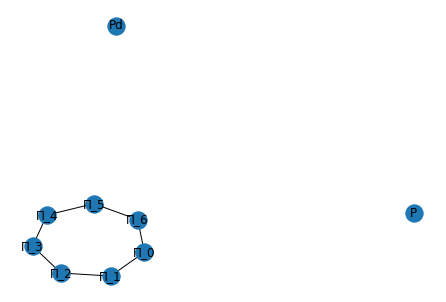

In [38]:
# #0 actual
# #1 KCBS
# #2 state only

# globalSettings({'cacheFolder':'cached_4_1_locMatDepth3/','N':7,'testType':0,'hDepth':3,'locMatDepth':2})

# #globalSettings({'cacheFolder':'cached_3/','N':7,'testType':0,'hDepth':3,'solverSettings':{'verbose':True,'solver':cp.MOSEK}})

# init()

In [42]:
# solve(constrFrac=0.5)

STEP  1 / 3  in progress...
Updating observed constraints
Observed values; Adding constraints
Done.
STEP  1 / 3  done.


STEP  2 / 3  in progress...
Readying the solver
Using only  37889  of the total  75779  constraints
STEP  2 / 3  done.


STEP  3 / 3  in progress...
Solving now
Initialising...
----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 172651
eps = 1.00e-04, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 102922, constraints m = 142541
Cones:	primal zero / dual free vars: 39619
	sd vars: 102922, sd blks: 2
Setup time: 2.62e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----

,0,1,2,3,4,5,6,7,8,9,...,438,439,440,441,442,443,444,445,446,447
0,1.000190,0.474645,0.473516,0.472873,0.472510,0.473401,0.475313,0.475864,0.149182,0.149806,...,0.315565,-0.065813,-0.141503,0.413215,-0.331568,0.459328,-0.203424,0.192442,0.129769,0.858712
1,0.474645,0.474442,-0.000007,0.379543,0.172748,0.162259,0.385953,-0.000011,-0.144716,0.447917,...,0.201471,-0.287577,-0.141506,0.000019,-0.273369,0.169746,-0.063691,0.157386,0.000004,0.459345
2,0.473516,-0.000007,0.473857,0.000013,0.374960,0.176939,0.162204,0.383932,0.451744,-0.166624,...,0.015738,0.222000,0.000005,0.413230,-0.000008,0.362554,-0.083302,0.064783,0.105454,0.348084
3,0.472873,0.379543,0.000013,0.473318,-0.000002,0.373802,0.175302,0.166323,-0.405610,0.112508,...,0.340989,-0.231079,-0.122295,0.000010,-0.331571,0.000005,-0.155351,0.070444,0.043937,0.459806
4,0.472510,0.172748,0.374960,-0.000002,0.473112,0.000006,0.377227,0.168614,0.543854,0.236633,...,-0.062102,0.072023,-0.035922,0.325437,0.000007,0.459329,-0.000010,0.153689,0.046999,0.367231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,0.459352,0.324884,0.189500,0.157087,0.352133,0.034294,0.409138,0.054619,0.236564,0.367197,...,-0.188946,0.144646,0.727184,0.103740,0.105581,0.665474,0.298542,0.187401,-0.177974,1.431395
444,-0.203438,0.204395,-0.359571,0.078636,-0.142676,-0.188994,0.112566,-0.378341,-0.261919,0.420716,...,0.256556,-0.007523,-0.148426,-0.147931,-0.201001,-0.480065,-0.444429,-0.157915,0.139834,-0.925916
445,0.192434,0.148822,0.167283,-0.109455,0.374551,-0.214970,0.356947,-0.086022,0.499221,0.419665,...,-0.216654,-0.083981,0.525255,0.050000,0.133030,0.584971,0.809458,0.447869,-0.109564,0.927719
446,0.129727,0.365903,-0.239292,0.300857,-0.065560,0.045603,0.211346,-0.189012,-0.371764,0.373474,...,0.282062,0.144068,0.083524,-0.274609,-0.135415,-0.139487,-0.761866,-0.340641,0.153208,-1.006613


Initialising...
----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 172651
eps = 1.00e-04, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 102922, constraints m = 142541
Cones:	primal zero / dual free vars: 39619
	sd vars: 102922, sd blks: 2
Setup time: 1.62e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.11e+21  3.26e+21  1.00e+00 -6.08e+21  1.28e+22  4.11e+20  1.35e-01 
   100| 9.36e-02  7.48e-02  3.17e-04 -1.06e+00 -1.07e+00  4.32e-16  9.47e+00 
   200| 4.69e-02  3.91e-02  2.01e-03 -1.01e+00 -1.00e

,0,1,2,3,4,5,6,7,8,9,...,438,439,440,441,442,443,444,445,446,447
0,1.000000,4.739422e-01,4.739092e-01,4.739540e-01,4.739707e-01,4.739649e-01,0.473958,4.739695e-01,0.159715,0.159715,...,0.353145,-0.083598,-1.571546e-01,4.738789e-01,-4.091339e-01,5.509087e-01,-2.960444e-01,0.270133,9.687405e-02,0.999799
1,0.473942,4.739462e-01,-6.633691e-07,3.800318e-01,1.691885e-01,1.691385e-01,0.380068,3.784911e-07,-0.157047,0.473926,...,0.244394,-0.327968,-1.571531e-01,-5.947072e-07,-3.280645e-01,1.966410e-01,-1.056552e-01,0.216615,1.394456e-07,0.473723
2,0.473909,-6.633691e-07,4.739322e-01,-7.065234e-07,3.800680e-01,1.691355e-01,0.169182,3.800409e-01,0.473935,-0.157099,...,-0.000027,0.244398,1.792613e-07,4.738799e-01,5.717809e-07,4.417904e-01,-1.056462e-01,0.096427,7.767623e-02,0.473899
3,0.473954,3.800318e-01,-7.065234e-07,4.739520e-01,-1.012464e-07,3.801069e-01,0.169100,1.692054e-01,-0.409126,0.096957,...,0.391969,-0.263049,-1.260123e-01,1.217569e-08,-4.091344e-01,6.540469e-07,-2.374235e-01,0.096382,3.458915e-02,0.473885
4,0.473971,1.691885e-01,3.800680e-01,-1.012464e-07,4.739617e-01,-1.733516e-08,0.380115,1.691097e-01,0.551056,0.270141,...,-0.069917,0.078972,-5.610624e-02,3.800297e-01,2.593787e-07,5.509081e-01,-9.319491e-07,0.216637,3.456437e-02,0.473767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,0.550906,3.800645e-01,2.269267e-01,2.037001e-01,3.986949e-01,7.060796e-02,0.466812,8.092525e-02,0.270141,0.473767,...,0.011749,0.019621,-1.356500e-01,2.300110e-01,-1.841849e-01,4.964879e-01,-1.306047e-01,0.201865,-4.091900e-02,0.310340
444,-0.296045,1.691269e-01,-4.090506e-01,3.452296e-02,-1.866221e-01,-2.316840e-01,0.070664,-4.291130e-01,-0.295944,0.474018,...,0.131565,-0.048673,-6.809430e-02,-4.080233e-01,-4.244527e-02,-2.140994e-01,1.607803e-02,-0.084015,-2.811755e-02,-0.109253
445,0.270132,1.691768e-01,2.269739e-01,-9.140963e-02,4.244677e-01,-1.866912e-01,0.398732,-4.504143e-02,0.550944,0.473697,...,-0.172498,0.024807,-6.561572e-02,2.309824e-01,7.189721e-02,2.498064e-01,3.414210e-02,0.111514,5.293174e-02,0.073378
446,0.096874,3.800332e-01,-2.831436e-01,3.047168e-01,-9.138945e-02,3.455237e-02,0.203708,-2.270747e-01,-0.409059,0.474012,...,0.237109,-0.114539,-1.365208e-01,-2.807287e-01,-2.718674e-01,-1.620255e-01,-1.788084e-01,0.054995,-6.724771e-02,-0.037756


STEP  3 / 3  done.




# Level 

In [ ]:
Level 3
State only
with observations

#############################
STEP  3 / 3  in progress...
Solving now
Initialising...
----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 143363
eps = 1.00e-04, alpha = 1.50, max_iters = 40000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 102922, constraints m = 122947
Cones:	primal zero / dual free vars: 20025
	sd vars: 102922, sd blks: 2
Setup time: 2.10e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.50e+01  2.21e+01  9.93e-01 -4.52e+01  8.83e+01  1.45e-14  1.94e-01 
   100| 5.16e-02  3.79e-02  5.95e-03  6.02e-02  5.36e-02  1.35e-16  7.17e+00 
   200| 3.16e-02  2.43e-02  5.39e-03  5.96e-02  6.57e-02  1.93e-16  1.39e+01 
   300| 2.12e-02  1.80e-02  2.65e-03  5.42e-02  5.72e-02  7.65e-17  2.06e+01 
   400| 2.39e-02  1.71e-02  1.93e-03  5.36e-02  5.58e-02  3.90e-16  2.73e+01 
   500| 1.71e-02  1.34e-02  1.88e-03  5.05e-02  5.26e-02  5.13e-17  3.40e+01 
   600| 1.45e-02  9.21e-03  1.43e-03  5.15e-02  5.31e-02  5.83e-16  4.07e+01 
   700| 8.94e-03  7.97e-03  6.29e-04  5.39e-02  5.46e-02  2.63e-16  4.72e+01 
   800| 1.41e-02  9.48e-03  5.48e-04  5.41e-02  5.47e-02  1.44e-16  5.38e+01 
   900| 9.58e-03  7.07e-03  1.29e-03  5.45e-02  5.60e-02  2.72e-16  6.02e+01 
  1000| 9.65e-03  8.80e-03  8.59e-04  5.29e-02  5.39e-02  1.31e-16  6.69e+01 
  1100| 1.01e-02  8.56e-03  1.23e-03  5.53e-02  5.67e-02  6.11e-16  7.35e+01 
  1200| 1.05e-02  7.49e-03  8.07e-04  5.54e-02  5.63e-02  6.37e-16  8.01e+01 
  1300| 7.15e-03  5.48e-03  8.92e-04  5.39e-02  5.48e-02  1.52e-16  8.67e+01 
  1400| 7.76e-03  5.63e-03  4.90e-04  5.33e-02  5.38e-02  2.50e-16  9.34e+01 
  1500| 6.93e-03  5.72e-03  9.99e-04  5.43e-02  5.55e-02  3.99e-16  9.98e+01 
  1600| 7.67e-03  5.64e-03  6.56e-04  5.48e-02  5.56e-02  2.33e-16  1.06e+02 
  1700| 6.57e-03  5.58e-03  6.81e-04  5.36e-02  5.44e-02  1.59e-16  1.13e+02 
  1800| 6.91e-03  4.75e-03  1.03e-03  5.30e-02  5.41e-02  4.39e-16  1.19e+02 
  1900| 7.07e-03  5.22e-03  1.03e-03  5.31e-02  5.43e-02  1.19e-16  1.26e+02 
  2000| 5.11e-03  3.98e-03  2.87e-04  5.26e-02  5.29e-02  6.48e-17  1.32e+02 
  2100| 6.17e-03  5.21e-03  2.04e-04  5.23e-02  5.25e-02  4.90e-17  1.38e+02 
  2200| 4.88e-03  4.16e-03  1.00e-03  5.22e-02  5.33e-02  2.28e-16  1.45e+02 
  2300| 7.51e-03  5.50e-03  3.13e-04  5.11e-02  5.07e-02  2.56e-16  1.51e+02 
  2400| 5.15e-03  3.87e-03  5.30e-04  5.21e-02  5.26e-02  8.36e-17  1.58e+02 
  2500| 5.69e-03  4.93e-03  7.66e-04  5.15e-02  5.24e-02  9.60e-17  1.64e+02 
  2600| 5.91e-03  5.28e-03  4.35e-04  5.12e-02  5.07e-02  4.98e-16  1.70e+02 
  2700| 5.02e-03  4.41e-03  8.88e-04  5.08e-02  5.18e-02  6.45e-16  1.77e+02 
  2800| 5.84e-03  4.27e-03  4.91e-04  4.99e-02  5.04e-02  2.51e-16  1.83e+02 
  2900| 5.32e-03  4.23e-03  5.31e-05  5.07e-02  5.07e-02  3.09e-16  1.90e+02 
  3000| 4.37e-03  3.60e-03  5.85e-04  5.03e-02  5.09e-02  5.76e-16  1.96e+02 
  3100| 4.52e-03  3.43e-03  6.18e-04  4.93e-02  5.00e-02  5.17e-16  2.02e+02 
  3200| 5.03e-03  4.52e-03  9.97e-06  4.98e-02  4.98e-02  5.59e-16  2.09e+02 
  3300| 4.20e-03  3.47e-03  8.62e-04  4.94e-02  5.04e-02  8.00e-16  2.15e+02 
  3400| 5.47e-03  4.03e-03  7.08e-05  4.89e-02  4.90e-02  1.74e-16  2.22e+02 
  3500| 3.92e-03  3.53e-03  4.53e-04  4.89e-02  4.94e-02  4.05e-16  2.28e+02 
  3600| 4.38e-03  3.46e-03  5.13e-04  4.85e-02  4.91e-02  1.83e-16  2.34e+02 
  3700| 3.57e-03  3.16e-03  9.01e-05  4.79e-02  4.80e-02  1.47e-16  2.41e+02 
  3800| 5.06e-03  3.81e-03  9.10e-04  4.84e-02  4.94e-02  3.20e-16  2.47e+02 
  3900| 3.70e-03  3.38e-03  4.20e-05  4.79e-02  4.80e-02  2.56e-16  2.54e+02 
  4000| 3.70e-03  2.64e-03  3.28e-04  4.77e-02  4.80e-02  2.53e-17  2.60e+02 
  4100| 5.82e-03  4.31e-03  7.05e-04  4.70e-02  4.78e-02  2.34e-16  2.66e+02 
  4200| 4.81e-03  3.78e-03  2.19e-04  4.74e-02  4.71e-02  1.77e-16  2.73e+02 
  4300| 3.77e-03  3.87e-03  7.25e-04  4.73e-02  4.81e-02  2.45e-16  2.79e+02 
  4400| 3.99e-03  2.73e-03  6.40e-04  4.67e-02  4.74e-02  9.61e-17  2.85e+02 
  4500| 3.61e-03  2.72e-03  3.50e-04  4.69e-02  4.73e-02  4.92e-17  2.92e+02 
  4600| 4.99e-03  4.23e-03  8.42e-04  4.66e-02  4.75e-02  7.49e-17  2.98e+02 
  4700| 4.14e-03  3.08e-03  1.52e-04  4.62e-02  4.64e-02  1.74e-16  3.05e+02 
  4800| 4.42e-03  3.17e-03  3.38e-04  4.64e-02  4.68e-02  4.06e-16  3.11e+02 
  4900| 4.02e-03  2.64e-03  3.83e-04  4.60e-02  4.65e-02  1.94e-16  3.18e+02 
  5000| 3.75e-03  3.34e-03  8.18e-06  4.60e-02  4.60e-02  2.30e-16  3.24e+02 
  5100| 4.66e-03  3.30e-03  9.50e-05  4.59e-02  4.58e-02  4.23e-16  3.31e+02 
  5200| 3.54e-03  2.80e-03  4.06e-04  4.59e-02  4.54e-02  1.17e-16  3.37e+02 
  5300| 3.27e-03  2.41e-03  8.16e-05  4.57e-02  4.56e-02  3.65e-16  3.43e+02 
  5400| 3.40e-03  3.15e-03  1.65e-04  4.54e-02  4.52e-02  3.91e-16  3.50e+02 
  5500| 3.14e-03  2.58e-03  1.77e-04  4.54e-02  4.52e-02  3.48e-16  3.56e+02 
  5600| 3.43e-03  2.68e-03  2.32e-04  4.50e-02  4.53e-02  1.79e-16  3.63e+02 
  5700| 4.85e-03  3.93e-03  2.11e-04  4.48e-02  4.50e-02  2.39e-16  3.69e+02 
  5800| 3.03e-03  2.76e-03  6.42e-04  4.48e-02  4.55e-02  3.08e-16  3.76e+02 
  5900| 3.91e-03  2.79e-03  6.22e-04  4.46e-02  4.53e-02  2.44e-16  3.82e+02 
  6000| 4.30e-03  3.84e-03  5.37e-04  4.44e-02  4.49e-02  1.86e-16  3.88e+02 
  6100| 3.29e-03  2.73e-03  8.00e-04  4.45e-02  4.54e-02  7.40e-16  3.95e+02 
  6200| 3.47e-03  2.90e-03  7.24e-04  4.42e-02  4.50e-02  2.33e-16  4.01e+02 
  6300| 3.05e-03  2.51e-03  5.84e-04  4.42e-02  4.49e-02  7.74e-16  4.08e+02 
  6400| 4.21e-03  3.44e-03  3.67e-05  4.45e-02  4.46e-02  9.83e-17  4.14e+02 
  6500| 2.34e-03  2.25e-03  2.59e-04  4.42e-02  4.40e-02  1.92e-16  4.21e+02 
  6600| 4.25e-03  3.47e-03  1.92e-05  4.42e-02  4.42e-02  9.34e-17  4.27e+02 
  6700| 2.76e-03  2.26e-03  1.22e-04  4.41e-02  4.40e-02  1.88e-16  4.34e+02 
  6800| 3.44e-03  2.67e-03  2.09e-04  4.37e-02  4.35e-02  1.51e-17  4.40e+02 
  6900| 3.11e-03  2.54e-03  3.66e-04  4.38e-02  4.34e-02  2.39e-16  4.46e+02 
  7000| 3.24e-03  2.46e-03  2.29e-06  4.37e-02  4.37e-02  6.73e-16  4.53e+02 
  7100| 3.11e-03  2.81e-03  2.53e-04  4.35e-02  4.38e-02  4.18e-16  4.59e+02 
  7200| 3.56e-03  2.36e-03  6.28e-04  4.33e-02  4.40e-02  7.78e-16  4.66e+02 
  7300| 3.05e-03  2.32e-03  5.94e-04  4.33e-02  4.39e-02  5.10e-16  4.72e+02 
  7400| 3.53e-03  2.85e-03  9.44e-04  4.30e-02  4.40e-02  3.18e-16  4.79e+02 
  7500| 2.98e-03  2.29e-03  4.92e-04  4.33e-02  4.38e-02  2.77e-16  4.85e+02 
  7600| 3.08e-03  2.32e-03  6.33e-04  4.29e-02  4.35e-02  7.89e-17  4.92e+02 
  7700| 2.23e-03  2.25e-03  2.02e-04  4.29e-02  4.31e-02  4.51e-17  4.98e+02 
  7800| 3.66e-03  3.05e-03  8.68e-05  4.29e-02  4.30e-02  1.28e-16  5.04e+02 
  7900| 2.70e-03  2.25e-03  1.87e-04  4.28e-02  4.26e-02  1.39e-16  5.11e+02 
  8000| 3.16e-03  2.35e-03  2.48e-04  4.28e-02  4.25e-02  9.24e-16  5.17e+02 
  8100| 2.99e-03  2.88e-03  2.16e-04  4.30e-02  4.28e-02  4.53e-16  5.24e+02 
  8200| 3.24e-03  2.65e-03  2.72e-04  4.25e-02  4.22e-02  2.36e-16  5.30e+02 
  8300| 2.29e-03  1.93e-03  2.03e-05  4.25e-02  4.25e-02  5.47e-16  5.37e+02 
  8400| 3.21e-03  2.59e-03  3.01e-04  4.25e-02  4.28e-02  2.11e-16  5.43e+02 
  8500| 2.48e-03  2.29e-03  3.98e-04  4.23e-02  4.27e-02  1.35e-16  5.49e+02 
  8600| 3.27e-03  2.31e-03  3.77e-04  4.24e-02  4.28e-02  4.24e-16  5.56e+02 
  8700| 1.85e-03  1.82e-03  5.43e-04  4.21e-02  4.27e-02  2.33e-16  5.62e+02 
  8800| 3.31e-03  2.65e-03  4.94e-04  4.21e-02  4.26e-02  2.55e-16  5.69e+02 
  8900| 2.79e-03  1.70e-03  4.45e-04  4.22e-02  4.27e-02  3.43e-17  5.75e+02 
  9000| 3.18e-03  2.61e-03  3.70e-04  4.19e-02  4.23e-02  2.93e-16  5.82e+02 
  9100| 2.25e-03  2.05e-03  2.26e-04  4.22e-02  4.19e-02  2.67e-16  5.88e+02 
  9200| 3.00e-03  2.24e-03  2.18e-04  4.21e-02  4.19e-02  1.72e-16  5.94e+02 
  9300| 2.45e-03  2.15e-03  1.89e-04  4.16e-02  4.14e-02  2.43e-16  6.01e+02 
  9400| 2.96e-03  2.21e-03  1.59e-04  4.19e-02  4.17e-02  8.00e-17  6.07e+02 
  9500| 2.81e-03  1.91e-03  1.45e-04  4.17e-02  4.16e-02  4.43e-16  6.14e+02 
  9600| 2.48e-03  2.33e-03  5.70e-05  4.15e-02  4.14e-02  8.08e-17  6.20e+02 
  9700| 3.27e-03  2.45e-03  3.77e-04  4.17e-02  4.21e-02  9.66e-17  6.27e+02 
  9800| 2.45e-03  1.74e-03  4.61e-04  4.15e-02  4.20e-02  4.95e-17  6.33e+02 
  9900| 2.21e-03  1.92e-03  4.38e-04  4.16e-02  4.20e-02  4.37e-16  6.39e+02 
 10000| 2.33e-03  1.90e-03  3.08e-04  4.16e-02  4.19e-02  8.92e-17  6.46e+02 
 10100| 2.38e-03  2.01e-03  1.26e-04  4.14e-02  4.16e-02  2.17e-16  6.52e+02 
 10200| 3.48e-03  2.58e-03  1.89e-05  4.15e-02  4.15e-02  3.38e-16  6.59e+02 
 10300| 2.44e-03  1.75e-03  4.39e-05  4.13e-02  4.12e-02  4.45e-16  6.65e+02 
 10400| 2.45e-03  1.81e-03  4.90e-05  4.12e-02  4.11e-02  1.08e-16  6.72e+02 
 10500| 2.40e-03  1.96e-03  1.25e-04  4.14e-02  4.12e-02  1.29e-16  6.78e+02 
 10600| 3.07e-03  2.53e-03  2.81e-04  4.12e-02  4.09e-02  3.29e-17  6.84e+02 
 10700| 2.57e-03  2.02e-03  9.39e-05  4.10e-02  4.11e-02  1.16e-17  6.91e+02 
 10800| 2.44e-03  2.06e-03  2.73e-04  4.09e-02  4.12e-02  2.38e-16  6.97e+02 
 10900| 2.84e-03  1.98e-03  3.09e-04  4.07e-02  4.11e-02  5.80e-17  7.04e+02 
 11000| 2.15e-03  1.85e-03  3.47e-04  4.11e-02  4.15e-02  2.75e-16  7.10e+02 
 11100| 2.47e-03  2.06e-03  5.60e-04  4.09e-02  4.15e-02  2.55e-16  7.17e+02 
 11200| 2.16e-03  1.95e-03  5.44e-04  4.06e-02  4.12e-02  1.21e-18  7.23e+02 
 11300| 2.13e-03  1.99e-03  3.51e-04  4.06e-02  4.10e-02  2.34e-16  7.30e+02 
 11400| 2.66e-03  1.94e-03  2.14e-05  4.08e-02  4.08e-02  6.22e-16  7.36e+02 
 11500| 1.97e-03  1.51e-03  1.41e-04  4.09e-02  4.07e-02  6.38e-17  7.42e+02 
 11600| 2.38e-03  1.81e-03  2.78e-04  4.10e-02  4.07e-02  1.85e-16  7.49e+02 
 11700| 2.98e-03  2.11e-03  1.78e-04  4.10e-02  4.08e-02  3.09e-16  7.55e+02 
 11800| 1.96e-03  1.72e-03  1.09e-04  4.04e-02  4.03e-02  4.66e-16  7.62e+02 
 11900| 2.30e-03  1.62e-03  8.88e-05  4.02e-02  4.03e-02  2.57e-16  7.68e+02 
 12000| 2.67e-03  1.71e-03  2.17e-04  4.01e-02  4.04e-02  5.87e-16  7.75e+02 
 12100| 2.52e-03  1.79e-03  2.72e-04  4.06e-02  4.09e-02  2.58e-19  7.81e+02 
 12200| 1.85e-03  1.59e-03  3.80e-04  4.06e-02  4.10e-02  6.40e-17  7.88e+02 
 12300| 1.67e-03  1.23e-03  3.84e-04  4.05e-02  4.09e-02  2.96e-16  7.94e+02 
 12400| 2.42e-03  2.16e-03  4.67e-04  4.05e-02  4.10e-02  3.05e-16  8.00e+02 
 12500| 2.36e-03  1.83e-03  2.87e-04  4.03e-02  4.06e-02  3.32e-16  8.07e+02 
 12600| 1.64e-03  1.47e-03  1.97e-04  4.00e-02  4.02e-02  1.50e-16  8.13e+02 
 12700| 2.28e-03  1.79e-03  8.28e-05  3.99e-02  4.00e-02  4.24e-16  8.20e+02 
 12800| 2.22e-03  1.86e-03  2.96e-05  4.02e-02  4.02e-02  2.91e-17  8.26e+02 
 12900| 1.80e-03  1.64e-03  2.12e-04  4.03e-02  4.00e-02  3.47e-16  8.33e+02 
 13000| 1.65e-03  1.44e-03  2.69e-04  4.04e-02  4.01e-02  7.38e-16  8.39e+02 
 13100| 1.64e-03  1.38e-03  8.92e-05  4.04e-02  4.03e-02  5.76e-16  8.46e+02 
 13200| 2.19e-03  1.63e-03  1.13e-04  3.99e-02  4.01e-02  3.00e-16  8.52e+02 
 13300| 1.54e-03  1.16e-03  1.28e-04  3.99e-02  4.00e-02  3.50e-16  8.59e+02 
 13400| 1.43e-03  1.24e-03  2.55e-04  3.97e-02  4.00e-02  2.13e-17  8.65e+02 
 13500| 1.84e-03  1.47e-03  2.82e-04  3.96e-02  3.99e-02  5.58e-17  8.72e+02 
 13600| 1.89e-03  1.75e-03  3.54e-04  3.98e-02  4.02e-02  2.46e-16  8.78e+02 
 13700| 1.73e-03  1.34e-03  3.50e-04  4.01e-02  4.04e-02  6.61e-17  8.85e+02 
 13800| 2.11e-03  1.64e-03  4.47e-04  3.98e-02  4.03e-02  5.62e-17  8.91e+02 
 13900| 1.78e-03  1.25e-03  1.91e-04  3.99e-02  4.01e-02  8.77e-17  8.97e+02 
 14000| 2.24e-03  1.69e-03  2.39e-04  3.93e-02  3.96e-02  2.03e-16  9.04e+02 
 14100| 1.93e-03  1.31e-03  1.09e-04  3.97e-02  3.96e-02  1.89e-16  9.10e+02 
 14200| 2.95e-03  2.22e-03  4.38e-04  3.98e-02  3.94e-02  4.64e-17  9.17e+02 
 14300| 1.54e-03  1.27e-03  1.65e-04  4.00e-02  3.98e-02  1.85e-16  9.23e+02 
 14400| 1.76e-03  1.61e-03  1.14e-05  3.98e-02  3.98e-02  4.01e-16  9.30e+02 
 14500| 2.38e-03  1.65e-03  2.73e-04  3.97e-02  4.00e-02  2.18e-17  9.36e+02 
 14600| 1.89e-03  1.39e-03  3.85e-04  3.93e-02  3.97e-02  6.61e-17  9.43e+02 
 14700| 2.17e-03  1.52e-03  3.55e-04  3.92e-02  3.96e-02  3.28e-17  9.49e+02 
 14800| 2.10e-03  1.79e-03  3.52e-04  3.92e-02  3.96e-02  1.38e-16  9.56e+02 
 14900| 1.61e-03  1.53e-03  3.95e-04  3.96e-02  4.00e-02  1.04e-16  9.62e+02 
 15000| 2.15e-03  1.70e-03  4.28e-04  3.95e-02  4.00e-02  9.54e-17  9.69e+02 
 15100| 1.69e-03  1.29e-03  1.17e-04  3.93e-02  3.94e-02  7.43e-16  9.75e+02 
 15200| 1.52e-03  1.26e-03  4.12e-05  3.92e-02  3.92e-02  3.10e-16  9.81e+02 
 15300| 2.53e-03  1.85e-03  1.06e-04  3.93e-02  3.91e-02  2.99e-16  9.88e+02 
 15400| 1.78e-03  1.55e-03  1.60e-04  3.95e-02  3.93e-02  6.74e-16  9.94e+02 
 15500| 2.28e-03  1.69e-03  2.40e-04  3.94e-02  3.91e-02  1.03e-16  1.00e+03 
 15600| 1.52e-03  1.45e-03  1.12e-04  3.93e-02  3.91e-02  6.85e-17  1.01e+03 
 15700| 2.38e-03  1.67e-03  1.91e-04  3.87e-02  3.89e-02  3.91e-16  1.01e+03 
 15800| 1.98e-03  1.72e-03  4.18e-04  3.90e-02  3.95e-02  6.71e-16  1.02e+03 
 15900| 1.78e-03  1.58e-03  4.35e-04  3.92e-02  3.97e-02  2.62e-16  1.03e+03 
 16000| 2.34e-03  1.87e-03  5.37e-04  3.90e-02  3.96e-02  8.05e-16  1.03e+03 
 16100| 2.00e-03  1.40e-03  4.68e-04  3.90e-02  3.95e-02  1.77e-16  1.04e+03 
 16200| 1.77e-03  1.52e-03  3.78e-04  3.88e-02  3.92e-02  6.14e-17  1.05e+03 
 16300| 1.90e-03  1.50e-03  2.07e-04  3.90e-02  3.93e-02  3.04e-16  1.05e+03 
 16400| 2.03e-03  1.39e-03  2.79e-06  3.91e-02  3.91e-02  2.39e-16  1.06e+03 
 16500| 1.66e-03  1.65e-03  1.65e-04  3.94e-02  3.92e-02  4.93e-16  1.07e+03 
 16600| 1.95e-03  1.78e-03  1.24e-04  3.90e-02  3.89e-02  4.55e-16  1.07e+03 
 16700| 1.97e-03  1.40e-03  2.19e-04  3.90e-02  3.88e-02  1.25e-16  1.08e+03 
 16800| 1.58e-03  1.30e-03  3.09e-05  3.90e-02  3.90e-02  4.56e-16  1.08e+03 
 16900| 1.98e-03  1.40e-03  4.95e-05  3.90e-02  3.90e-02  1.12e-16  1.09e+03 
 17000| 1.83e-03  1.49e-03  9.73e-05  3.87e-02  3.86e-02  9.66e-16  1.10e+03 
 17100| 2.15e-03  1.42e-03  1.31e-04  3.85e-02  3.87e-02  1.64e-16  1.10e+03 
 17200| 1.86e-03  1.53e-03  3.58e-04  3.89e-02  3.93e-02  6.41e-16  1.11e+03 
 17300| 1.71e-03  1.52e-03  3.04e-04  3.88e-02  3.92e-02  2.17e-16  1.12e+03 
 17400| 1.78e-03  1.31e-03  3.69e-04  3.87e-02  3.91e-02  3.03e-17  1.12e+03 
 17500| 1.69e-03  1.64e-03  3.16e-04  3.84e-02  3.87e-02  2.61e-16  1.13e+03 
 17600| 1.84e-03  1.41e-03  2.54e-04  3.87e-02  3.89e-02  1.90e-16  1.14e+03 
 17700| 1.60e-03  1.10e-03  1.26e-04  3.88e-02  3.89e-02  4.52e-17  1.14e+03 
 17800| 2.07e-03  1.54e-03  5.71e-05  3.87e-02  3.88e-02  3.78e-16  1.15e+03 
 17900| 2.22e-03  1.56e-03  2.03e-04  3.83e-02  3.81e-02  1.27e-16  1.16e+03 
 18000| 1.84e-03  1.36e-03  4.66e-06  3.86e-02  3.86e-02  1.89e-16  1.16e+03 
 18100| 1.60e-03  1.27e-03  1.31e-04  3.87e-02  3.86e-02  1.37e-17  1.17e+03 
 18200| 1.66e-03  1.56e-03  1.57e-04  3.85e-02  3.83e-02  1.56e-16  1.17e+03 
 18300| 1.74e-03  1.30e-03  8.81e-05  3.83e-02  3.82e-02  2.15e-16  1.18e+03 
 18400| 1.31e-03  1.08e-03  1.81e-05  3.83e-02  3.83e-02  2.36e-16  1.19e+03 
 18500| 2.90e-03  2.46e-03  1.07e-04  3.86e-02  3.87e-02  2.30e-16  1.19e+03 
 18600| 1.42e-03  1.03e-03  1.97e-04  3.83e-02  3.85e-02  7.83e-17  1.20e+03 
 18700| 1.94e-03  1.44e-03  2.43e-04  3.82e-02  3.84e-02  8.08e-17  1.21e+03 
 18800| 1.52e-03  1.37e-03  2.69e-04  3.82e-02  3.85e-02  4.66e-16  1.21e+03 
 18900| 2.01e-03  1.33e-03  3.85e-04  3.85e-02  3.89e-02  9.06e-17  1.22e+03 
 19000| 1.76e-03  1.35e-03  2.98e-04  3.83e-02  3.86e-02  3.46e-17  1.23e+03 
 19100| 1.83e-03  1.44e-03  1.37e-04  3.80e-02  3.82e-02  1.17e-17  1.23e+03 
 19200| 1.70e-03  1.33e-03  3.16e-05  3.83e-02  3.83e-02  3.76e-16  1.24e+03 
 19300| 2.03e-03  1.35e-03  2.66e-04  3.85e-02  3.82e-02  2.02e-16  1.25e+03 
 19400| 1.92e-03  1.80e-03  2.06e-04  3.83e-02  3.81e-02  2.69e-17  1.25e+03 
 19500| 1.49e-03  1.20e-03  1.31e-04  3.82e-02  3.81e-02  1.55e-18  1.26e+03 
 19600| 1.91e-03  1.52e-03  3.69e-05  3.80e-02  3.80e-02  4.43e-16  1.27e+03 
 19700| 2.01e-03  1.61e-03  5.89e-05  3.81e-02  3.82e-02  1.26e-16  1.27e+03 
 19800| 2.04e-03  1.65e-03  1.08e-04  3.82e-02  3.83e-02  9.58e-17  1.28e+03 
 19900| 2.04e-03  1.46e-03  1.76e-04  3.79e-02  3.80e-02  1.80e-16  1.28e+03 
 20000| 1.72e-03  1.62e-03  3.29e-04  3.79e-02  3.82e-02  1.10e-16  1.29e+03 
 20100| 1.49e-03  1.26e-03  2.69e-04  3.81e-02  3.84e-02  9.61e-17  1.30e+03 
 20200| 1.23e-03  1.04e-03  6.53e-05  3.83e-02  3.82e-02  2.41e-17  1.30e+03 
 20300| 1.31e-03  1.05e-03  6.27e-05  3.82e-02  3.81e-02  1.67e-16  1.31e+03 
 20400| 1.81e-03  1.43e-03  1.83e-05  3.78e-02  3.78e-02  5.73e-16  1.32e+03 
 20500| 1.57e-03  1.32e-03  1.80e-04  3.81e-02  3.79e-02  7.75e-18  1.32e+03 
 20600| 1.87e-03  1.51e-03  1.56e-04  3.82e-02  3.81e-02  4.39e-16  1.33e+03 
 20700| 1.57e-03  1.30e-03  5.05e-05  3.78e-02  3.78e-02  3.54e-16  1.34e+03 
 20800| 1.60e-03  1.34e-03  8.17e-05  3.79e-02  3.80e-02  2.28e-16  1.34e+03 
 20900| 1.76e-03  1.31e-03  1.56e-04  3.78e-02  3.80e-02  1.48e-16  1.35e+03 
 21000| 1.39e-03  1.12e-03  1.92e-04  3.78e-02  3.80e-02  5.63e-16  1.36e+03 
 21100| 1.71e-03  1.40e-03  2.49e-04  3.78e-02  3.81e-02  3.26e-16  1.36e+03 
 21200| 1.55e-03  1.18e-03  2.76e-04  3.76e-02  3.79e-02  1.34e-16  1.37e+03 
 21300| 1.61e-03  1.13e-03  1.32e-04  3.78e-02  3.79e-02  2.89e-16  1.37e+03 
 21400| 1.47e-03  1.31e-03  8.33e-05  3.79e-02  3.78e-02  1.31e-17  1.38e+03 
 21500| 1.50e-03  1.01e-03  5.31e-05  3.75e-02  3.74e-02  2.06e-16  1.39e+03 
 21600| 2.23e-03  2.01e-03  1.38e-04  3.80e-02  3.79e-02  3.56e-17  1.39e+03 
 21700| 1.40e-03  1.23e-03  1.62e-04  3.80e-02  3.78e-02  1.42e-16  1.40e+03 
 21800| 2.03e-03  1.54e-03  1.94e-04  3.76e-02  3.74e-02  1.54e-16  1.41e+03 
 21900| 1.31e-03  1.12e-03  8.79e-05  3.75e-02  3.76e-02  2.94e-16  1.41e+03 
 22000| 1.85e-03  1.29e-03  1.99e-04  3.76e-02  3.78e-02  4.87e-16  1.42e+03 
 22100| 1.12e-03  1.15e-03  2.32e-04  3.77e-02  3.79e-02  2.69e-17  1.43e+03 
 22200| 1.98e-03  1.46e-03  3.51e-04  3.76e-02  3.80e-02  4.04e-17  1.43e+03 
 22300| 1.16e-03  1.08e-03  1.86e-04  3.77e-02  3.79e-02  5.56e-17  1.44e+03 
 22400| 1.49e-03  1.19e-03  6.95e-05  3.74e-02  3.75e-02  1.07e-16  1.45e+03 
 22500| 1.41e-03  1.31e-03  4.28e-05  3.77e-02  3.77e-02  2.42e-16  1.45e+03 
 22600| 1.49e-03  1.11e-03  3.00e-05  3.79e-02  3.78e-02  3.74e-17  1.46e+03 
 22700| 2.08e-03  1.79e-03  1.22e-04  3.74e-02  3.72e-02  2.68e-16  1.47e+03 
 22800| 1.28e-03  1.35e-03  1.04e-04  3.74e-02  3.73e-02  3.66e-17  1.47e+03 
 22900| 1.94e-03  1.24e-03  8.86e-05  3.77e-02  3.76e-02  2.65e-16  1.48e+03 
 23000| 1.32e-03  1.35e-03  1.25e-04  3.76e-02  3.78e-02  2.65e-18  1.49e+03 
 23100| 1.50e-03  1.17e-03  2.10e-04  3.73e-02  3.75e-02  2.36e-17  1.49e+03 
 23200| 1.39e-03  1.25e-03  1.79e-04  3.73e-02  3.75e-02  3.67e-16  1.50e+03 
 23300| 1.49e-03  1.41e-03  1.83e-04  3.74e-02  3.76e-02  5.88e-16  1.50e+03 
 23400| 1.72e-03  1.42e-03  2.48e-04  3.73e-02  3.76e-02  2.27e-16  1.51e+03 
 23500| 1.46e-03  1.11e-03  1.92e-04  3.73e-02  3.75e-02  1.04e-16  1.52e+03 
 23600| 1.72e-03  1.37e-03  1.88e-04  3.74e-02  3.76e-02  3.75e-16  1.52e+03 
 23700| 1.52e-03  1.24e-03  9.63e-05  3.74e-02  3.73e-02  2.03e-16  1.53e+03 
 23800| 1.22e-03  1.04e-03  4.01e-05  3.74e-02  3.74e-02  1.49e-16  1.54e+03 
 23900| 2.08e-03  1.57e-03  2.69e-04  3.76e-02  3.73e-02  3.92e-17  1.54e+03 
 24000| 1.29e-03  1.28e-03  1.04e-04  3.73e-02  3.72e-02  6.22e-16  1.55e+03 
 24100| 1.20e-03  9.11e-04  6.06e-06  3.72e-02  3.72e-02  2.70e-16  1.56e+03 
 24200| 2.54e-03  1.92e-03  2.89e-04  3.74e-02  3.71e-02  2.71e-17  1.56e+03 
 24300| 1.53e-03  1.17e-03  9.52e-05  3.73e-02  3.72e-02  4.31e-17  1.57e+03 
 24400| 1.55e-03  1.14e-03  2.54e-05  3.72e-02  3.72e-02  3.39e-16  1.58e+03 
 24500| 1.72e-03  1.34e-03  3.46e-05  3.70e-02  3.70e-02  4.71e-17  1.58e+03 
 24600| 1.40e-03  9.42e-04  1.17e-04  3.72e-02  3.73e-02  2.15e-16  1.59e+03 
 24700| 1.40e-03  1.06e-03  1.84e-04  3.72e-02  3.74e-02  3.89e-17  1.60e+03 
 24800| 1.87e-03  1.89e-03  4.21e-04  3.69e-02  3.74e-02  1.22e-16  1.60e+03 
 24900| 1.72e-03  1.26e-03  2.92e-04  3.67e-02  3.70e-02  2.59e-16  1.61e+03 
 25000| 1.29e-03  1.19e-03  2.22e-04  3.70e-02  3.72e-02  2.10e-17  1.61e+03 
 25100| 1.14e-03  9.21e-04  1.55e-04  3.72e-02  3.74e-02  6.49e-16  1.62e+03 
 25200| 1.38e-03  1.16e-03  9.68e-05  3.72e-02  3.73e-02  3.05e-16  1.63e+03 
 25300| 1.10e-03  9.54e-04  3.00e-05  3.70e-02  3.70e-02  3.10e-16  1.63e+03 
 25400| 1.40e-03  9.92e-04  3.34e-05  3.70e-02  3.70e-02  3.59e-16  1.64e+03 
 25500| 1.39e-03  1.23e-03  9.19e-05  3.71e-02  3.70e-02  1.30e-16  1.65e+03 
 25600| 1.41e-03  1.18e-03  1.64e-04  3.71e-02  3.69e-02  1.68e-16  1.65e+03 
 25700| 1.41e-03  1.25e-03  1.64e-04  3.69e-02  3.67e-02  4.37e-16  1.66e+03 
 25800| 1.23e-03  9.94e-04  6.38e-05  3.70e-02  3.70e-02  1.98e-16  1.67e+03 
 25900| 1.76e-03  1.18e-03  7.48e-05  3.70e-02  3.69e-02  3.20e-17  1.67e+03 
 26000| 1.23e-03  1.16e-03  5.39e-05  3.71e-02  3.71e-02  1.96e-16  1.68e+03 
 26100| 1.28e-03  8.40e-04  2.06e-05  3.70e-02  3.70e-02  5.79e-16  1.69e+03 
 26200| 1.16e-03  9.28e-04  8.95e-05  3.69e-02  3.70e-02  3.44e-16  1.69e+03 
 26300| 1.26e-03  1.22e-03  2.23e-04  3.69e-02  3.72e-02  4.88e-16  1.70e+03 
 26400| 1.11e-03  9.07e-04  1.86e-04  3.71e-02  3.73e-02  3.62e-16  1.71e+03 
 26500| 1.45e-03  1.12e-03  1.84e-04  3.68e-02  3.70e-02  6.05e-16  1.71e+03 
 26600| 1.20e-03  9.23e-04  1.31e-04  3.68e-02  3.69e-02  1.68e-16  1.72e+03 
 26700| 1.51e-03  1.28e-03  1.55e-04  3.68e-02  3.69e-02  9.15e-17  1.73e+03 
 26800| 1.51e-03  1.25e-03  1.68e-04  3.68e-02  3.70e-02  1.08e-16  1.73e+03 
 26900| 1.44e-03  1.10e-03  2.21e-04  3.69e-02  3.71e-02  4.57e-17  1.74e+03 
 27000| 1.15e-03  1.01e-03  1.85e-04  3.68e-02  3.70e-02  3.49e-16  1.74e+03 
 27100| 9.69e-04  7.98e-04  1.31e-04  3.67e-02  3.68e-02  1.97e-16  1.75e+03 
 27200| 1.55e-03  1.16e-03  9.27e-05  3.68e-02  3.69e-02  2.43e-16  1.76e+03 
 27300| 1.40e-03  1.18e-03  2.94e-05  3.68e-02  3.69e-02  7.04e-16  1.76e+03 
 27400| 1.47e-03  1.15e-03  4.68e-05  3.68e-02  3.68e-02  2.52e-16  1.77e+03 
 27500| 1.29e-03  9.77e-04  3.10e-06  3.67e-02  3.67e-02  7.37e-16  1.78e+03 
 27600| 1.86e-03  1.45e-03  6.58e-05  3.66e-02  3.67e-02  5.48e-16  1.78e+03 
 27700| 2.01e-03  1.62e-03  3.03e-05  3.68e-02  3.68e-02  3.87e-16  1.79e+03 
 27800| 1.10e-03  8.09e-04  1.77e-05  3.67e-02  3.68e-02  5.56e-17  1.80e+03 
 27900| 1.38e-03  9.13e-04  6.01e-05  3.69e-02  3.70e-02  3.62e-17  1.80e+03 
 28000| 1.67e-03  1.13e-03  4.63e-05  3.66e-02  3.67e-02  6.98e-16  1.81e+03 
 28100| 9.08e-04  8.22e-04  2.30e-05  3.66e-02  3.66e-02  6.56e-16  1.82e+03 
 28200| 1.15e-03  1.02e-03  6.24e-05  3.66e-02  3.65e-02  2.77e-16  1.82e+03 
 28300| 1.49e-03  1.16e-03  1.07e-04  3.67e-02  3.66e-02  3.75e-16  1.83e+03 
 28400| 1.14e-03  1.19e-03  2.82e-05  3.67e-02  3.67e-02  2.22e-16  1.84e+03 
 28500| 1.58e-03  1.21e-03  1.24e-05  3.65e-02  3.65e-02  2.00e-17  1.84e+03 
 28600| 1.33e-03  1.07e-03  1.13e-04  3.63e-02  3.62e-02  7.17e-17  1.85e+03 
 28700| 2.09e-03  1.66e-03  2.98e-04  3.65e-02  3.62e-02  5.37e-16  1.85e+03 
 28800| 1.17e-03  9.14e-04  5.50e-05  3.66e-02  3.66e-02  3.43e-16  1.86e+03 
 28900| 1.44e-03  1.24e-03  1.04e-04  3.66e-02  3.65e-02  2.65e-17  1.87e+03 
 29000| 1.32e-03  9.89e-04  2.07e-05  3.65e-02  3.65e-02  2.07e-16  1.87e+03 
 29100| 1.36e-03  1.12e-03  8.15e-06  3.64e-02  3.64e-02  1.01e-16  1.88e+03 
 29200| 8.60e-04  8.15e-04  5.59e-05  3.64e-02  3.65e-02  7.61e-16  1.89e+03 
 29300| 1.10e-03  8.56e-04  8.23e-05  3.65e-02  3.66e-02  7.79e-16  1.89e+03 
 29400| 1.54e-03  1.21e-03  1.19e-04  3.65e-02  3.67e-02  2.46e-16  1.90e+03 
 29500| 1.68e-03  1.12e-03  1.25e-04  3.64e-02  3.66e-02  7.32e-16  1.91e+03 
 29600| 1.61e-03  1.33e-03  1.69e-04  3.63e-02  3.65e-02  3.61e-16  1.91e+03 
 29700| 1.35e-03  1.12e-03  1.67e-04  3.61e-02  3.63e-02  2.43e-16  1.92e+03 
 29800| 1.39e-03  1.43e-03  1.96e-04  3.61e-02  3.63e-02  4.10e-16  1.93e+03 
 29900| 1.53e-03  1.06e-03  1.75e-04  3.63e-02  3.65e-02  7.93e-16  1.93e+03 
 30000| 1.30e-03  1.13e-03  1.67e-04  3.64e-02  3.65e-02  2.76e-16  1.94e+03 
 30100| 2.47e-03  2.22e-03  1.26e-04  3.64e-02  3.65e-02  7.14e-16  1.95e+03 
 30200| 1.46e-03  1.33e-03  1.63e-04  3.64e-02  3.65e-02  8.79e-17  1.95e+03 
 30300| 1.32e-03  1.06e-03  1.43e-04  3.62e-02  3.63e-02  1.08e-17  1.96e+03 
 30400| 8.22e-04  7.89e-04  1.19e-04  3.63e-02  3.65e-02  2.96e-16  1.96e+03 
 30500| 1.07e-03  8.46e-04  1.44e-04  3.62e-02  3.63e-02  8.26e-16  1.97e+03 
 30600| 1.44e-03  1.13e-03  1.53e-04  3.62e-02  3.64e-02  3.05e-16  1.98e+03 
 30700| 1.01e-03  7.58e-04  1.74e-04  3.63e-02  3.65e-02  7.04e-16  1.98e+03 
 30800| 9.31e-04  7.59e-04  9.77e-05  3.63e-02  3.64e-02  1.23e-16  1.99e+03 
 30900| 1.15e-03  1.02e-03  1.36e-04  3.63e-02  3.64e-02  9.29e-17  2.00e+03 
 31000| 1.37e-03  1.08e-03  1.26e-04  3.61e-02  3.62e-02  7.13e-16  2.00e+03 
 31100| 1.21e-03  1.00e-03  9.74e-05  3.61e-02  3.62e-02  4.16e-16  2.01e+03 
 31200| 1.17e-03  9.00e-04  9.39e-05  3.61e-02  3.62e-02  5.94e-16  2.02e+03 
 31300| 1.38e-03  9.15e-04  7.21e-05  3.63e-02  3.64e-02  4.36e-16  2.02e+03 
 31400| 1.07e-03  9.35e-04  7.31e-05  3.62e-02  3.63e-02  3.16e-16  2.03e+03 
 31500| 1.26e-03  9.92e-04  5.83e-05  3.62e-02  3.61e-02  8.23e-16  2.04e+03 
 31600| 1.21e-03  9.30e-04  2.52e-05  3.61e-02  3.61e-02  3.89e-16  2.04e+03 
 31700| 1.93e-03  1.44e-03  9.38e-05  3.62e-02  3.61e-02  1.43e-16  2.05e+03 
 31800| 1.55e-03  1.39e-03  1.10e-04  3.60e-02  3.61e-02  1.44e-16  2.06e+03 
 31900| 1.74e-03  1.29e-03  2.88e-05  3.61e-02  3.61e-02  2.40e-16  2.06e+03 
 32000| 1.10e-03  9.27e-04  2.04e-05  3.62e-02  3.62e-02  2.81e-16  2.07e+03 
 32100| 1.54e-03  1.16e-03  1.67e-04  3.62e-02  3.61e-02  1.34e-16  2.07e+03 
 32200| 1.13e-03  8.68e-04  5.20e-05  3.62e-02  3.62e-02  2.97e-16  2.08e+03 
 32300| 1.03e-03  9.05e-04  8.48e-06  3.61e-02  3.61e-02  1.48e-16  2.09e+03 
 32400| 1.24e-03  1.06e-03  1.15e-05  3.60e-02  3.60e-02  8.84e-16  2.09e+03 
 32500| 1.24e-03  9.42e-04  1.07e-04  3.60e-02  3.61e-02  1.51e-16  2.10e+03 
 32600| 1.32e-03  1.03e-03  8.50e-05  3.59e-02  3.60e-02  5.70e-16  2.11e+03 
 32700| 8.72e-04  8.12e-04  1.21e-04  3.60e-02  3.61e-02  3.70e-16  2.11e+03 
 32800| 1.24e-03  9.62e-04  1.31e-04  3.60e-02  3.61e-02  1.62e-16  2.12e+03 
 32900| 1.45e-03  1.19e-03  1.74e-04  3.60e-02  3.62e-02  9.36e-17  2.13e+03 
 33000| 1.15e-03  1.01e-03  2.24e-04  3.60e-02  3.62e-02  3.97e-16  2.13e+03 
 33100| 9.06e-04  8.55e-04  2.11e-04  3.60e-02  3.62e-02  7.85e-16  2.14e+03 
 33200| 1.41e-03  1.16e-03  2.65e-04  3.59e-02  3.62e-02  1.06e-16  2.15e+03 
 33300| 1.20e-03  8.98e-04  2.10e-04  3.58e-02  3.61e-02  3.66e-16  2.15e+03 
 33400| 1.10e-03  8.14e-04  1.02e-04  3.59e-02  3.60e-02  2.96e-16  2.16e+03 
 33500| 2.34e-03  1.83e-03  3.81e-04  3.56e-02  3.61e-02  1.62e-16  2.17e+03 
 33600| 1.17e-03  1.11e-03  2.53e-04  3.56e-02  3.59e-02  1.10e-16  2.17e+03 
 33700| 1.16e-03  7.92e-04  1.97e-04  3.58e-02  3.60e-02  3.53e-16  2.18e+03 
 33800| 1.05e-03  8.73e-04  1.07e-04  3.58e-02  3.59e-02  4.70e-16  2.19e+03 
 33900| 1.30e-03  1.08e-03  1.81e-04  3.59e-02  3.60e-02  6.21e-17  2.19e+03 
 34000| 1.24e-03  1.13e-03  2.28e-04  3.57e-02  3.60e-02  3.30e-16  2.20e+03 
 34100| 1.30e-03  1.23e-03  1.40e-04  3.62e-02  3.63e-02  1.59e-16  2.20e+03 
 34200| 9.46e-04  8.29e-04  1.55e-04  3.55e-02  3.57e-02  4.61e-16  2.21e+03 
 34300| 1.50e-03  1.19e-03  2.49e-04  3.57e-02  3.60e-02  8.58e-16  2.22e+03 
 34400| 1.08e-03  8.34e-04  1.94e-04  3.58e-02  3.61e-02  4.23e-16  2.22e+03 
 34500| 9.78e-04  7.05e-04  1.18e-04  3.58e-02  3.60e-02  2.87e-16  2.23e+03 
 34600| 1.29e-03  9.73e-04  1.14e-04  3.58e-02  3.59e-02  8.15e-16  2.24e+03 
 34700| 1.51e-03  1.23e-03  9.24e-05  3.58e-02  3.59e-02  2.92e-16  2.24e+03 
 34800| 1.12e-03  8.15e-04  5.09e-05  3.59e-02  3.59e-02  4.59e-16  2.25e+03 
 34900| 1.18e-03  8.55e-04  6.65e-06  3.57e-02  3.57e-02  3.49e-16  2.26e+03 
 35000| 1.41e-03  9.79e-04  5.94e-06  3.58e-02  3.58e-02  1.47e-16  2.26e+03 
 35100| 1.23e-03  1.07e-03  5.71e-05  3.58e-02  3.57e-02  4.72e-16  2.27e+03 
 35200| 1.09e-03  9.95e-04  9.68e-05  3.57e-02  3.56e-02  8.12e-16  2.28e+03 
 35300| 1.08e-03  7.15e-04  8.43e-05  3.57e-02  3.56e-02  2.06e-16  2.28e+03 
 35400| 1.50e-03  1.33e-03  5.64e-05  3.58e-02  3.57e-02  1.57e-16  2.29e+03 
 35500| 1.87e-03  1.46e-03  2.35e-04  3.56e-02  3.54e-02  2.35e-16  2.29e+03 
 35600| 9.07e-04  6.89e-04  9.05e-05  3.56e-02  3.56e-02  8.18e-16  2.30e+03 
 35700| 1.02e-03  8.81e-04  4.43e-05  3.56e-02  3.55e-02  4.75e-16  2.31e+03 
 35800| 1.03e-03  8.79e-04  4.32e-05  3.57e-02  3.56e-02  6.72e-16  2.31e+03 
 35900| 1.01e-03  6.75e-04  5.87e-05  3.56e-02  3.57e-02  4.15e-17  2.32e+03 
 36000| 8.88e-04  7.89e-04  9.79e-05  3.56e-02  3.57e-02  1.73e-16  2.33e+03 
 36100| 1.26e-03  1.20e-03  2.50e-04  3.56e-02  3.58e-02  6.29e-16  2.33e+03 
 36200| 8.58e-04  6.88e-04  1.91e-04  3.56e-02  3.58e-02  1.51e-16  2.34e+03 
 36300| 9.44e-04  7.46e-04  1.57e-04  3.56e-02  3.58e-02  1.86e-16  2.35e+03 
 36400| 1.03e-03  9.74e-04  1.56e-04  3.56e-02  3.58e-02  1.00e-17  2.35e+03 
 36500| 8.86e-04  7.07e-04  6.30e-05  3.56e-02  3.57e-02  3.36e-16  2.36e+03 
 36600| 2.03e-03  1.67e-03  4.11e-05  3.54e-02  3.55e-02  1.78e-16  2.37e+03 
 36700| 1.13e-03  8.10e-04  4.11e-05  3.57e-02  3.56e-02  9.01e-17  2.37e+03 
 36800| 1.18e-03  8.52e-04  2.16e-05  3.56e-02  3.56e-02  3.96e-16  2.38e+03 
 36900| 9.27e-04  8.52e-04  5.05e-05  3.56e-02  3.55e-02  1.35e-16  2.39e+03 
 37000| 1.31e-03  1.06e-03  1.28e-04  3.56e-02  3.54e-02  3.98e-17  2.39e+03 
 37100| 8.59e-04  7.62e-04  5.63e-05  3.56e-02  3.56e-02  1.51e-16  2.40e+03 
 37200| 1.52e-03  1.37e-03  5.16e-05  3.56e-02  3.55e-02  4.95e-16  2.40e+03 
 37300| 1.58e-03  1.21e-03  3.18e-05  3.56e-02  3.55e-02  1.53e-16  2.41e+03 
 37400| 1.71e-03  1.34e-03  8.45e-05  3.55e-02  3.56e-02  2.57e-17  2.42e+03 
 37500| 1.81e-03  1.26e-03  3.58e-05  3.54e-02  3.55e-02  9.09e-17  2.42e+03 
 37600| 1.24e-03  9.79e-04  1.67e-04  3.55e-02  3.57e-02  1.96e-16  2.43e+03 
 37700| 9.75e-04  9.63e-04  1.73e-04  3.56e-02  3.57e-02  7.78e-17  2.44e+03 
 37800| 1.17e-03  7.32e-04  1.36e-04  3.54e-02  3.56e-02  9.44e-18  2.44e+03 
 37900| 9.09e-04  7.42e-04  2.03e-05  3.55e-02  3.55e-02  1.82e-16  2.45e+03 
 38000| 1.16e-03  9.83e-04  1.34e-04  3.55e-02  3.54e-02  5.45e-17  2.46e+03 
 38100| 9.00e-04  7.32e-04  1.20e-04  3.54e-02  3.53e-02  1.46e-16  2.46e+03 
 38200| 9.54e-04  9.02e-04  1.15e-04  3.55e-02  3.54e-02  2.03e-17  2.47e+03 
 38300| 8.74e-04  7.70e-04  1.46e-05  3.54e-02  3.53e-02  4.76e-16  2.48e+03 
 38400| 8.94e-04  7.62e-04  4.33e-05  3.54e-02  3.54e-02  1.09e-16  2.48e+03 
 38500| 1.19e-03  1.12e-03  1.15e-04  3.53e-02  3.55e-02  2.14e-16  2.49e+03 
 38600| 1.90e-03  1.29e-03  1.95e-04  3.54e-02  3.56e-02  1.61e-16  2.50e+03 
 38700| 1.35e-03  1.22e-03  2.05e-04  3.50e-02  3.52e-02  7.15e-17  2.50e+03 
 38800| 1.52e-03  1.12e-03  2.37e-04  3.52e-02  3.54e-02  2.32e-17  2.51e+03 
 38900| 1.23e-03  9.61e-04  5.81e-05  3.53e-02  3.54e-02  4.21e-16  2.51e+03 
 39000| 8.51e-04  7.94e-04  9.66e-05  3.55e-02  3.54e-02  1.81e-17  2.52e+03 
 39100| 1.48e-03  1.02e-03  1.59e-04  3.54e-02  3.52e-02  1.60e-16  2.53e+03 
 39200| 1.14e-03  1.03e-03  5.86e-05  3.54e-02  3.53e-02  4.93e-16  2.53e+03 
 39300| 8.91e-04  5.95e-04  1.17e-04  3.53e-02  3.54e-02  1.78e-16  2.54e+03 
 39400| 1.22e-03  1.14e-03  2.19e-04  3.53e-02  3.55e-02  1.30e-16  2.55e+03 
 39500| 9.48e-04  7.53e-04  1.65e-04  3.53e-02  3.55e-02  1.11e-16  2.55e+03 
 39600| 9.88e-04  7.89e-04  1.68e-05  3.53e-02  3.53e-02  5.55e-17  2.56e+03 
 39700| 7.92e-04  7.13e-04  1.36e-04  3.53e-02  3.52e-02  4.19e-17  2.57e+03 
 39800| 9.35e-04  6.67e-04  9.20e-05  3.53e-02  3.52e-02  1.97e-16  2.57e+03 
 39900| 9.43e-04  8.95e-04  1.76e-05  3.52e-02  3.52e-02  1.07e-16  2.58e+03 
 40000| 1.36e-03  1.02e-03  1.19e-04  3.53e-02  3.52e-02  2.72e-16  2.59e+03 
----------------------------------------------------------------------------
Status: Solved/Inaccurate
Hit max_iters, solution may be inaccurate
Timing: Solve time: 2.59e+03s
	Lin-sys: nnz in L factor: 381143, avg solve time: 2.27e-03s
	Cones: avg projection time: 3.88e-02s
	Acceleration: avg step time: 1.73e-02s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 3.1803e-09, dist(y, K*) = 1.2422e-09, s'y/|s||y| = 7.5023e-14
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.3645e-03
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.0151e-03
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.1918e-04
----------------------------------------------------------------------------
c'x = 0.0353, -b'y = 0.0352
============================================================================
min: 0.03532336295681052
sqrt(5) 2.23606797749979
0	1	2	3	4	5	6	7	8	9	...	438	439	440	441	442	443	444	445	446	447
0	0.999978	4.740476e-01	4.740103e-01	0.473903	0.473848	0.473941	0.473908	0.473937	0.345744	0.345744	...	0.154895	-0.158862	1.714146e-02	-3.729804e-01	4.569384e-02	-3.188660e-01	-0.081014	-0.144818	-2.675682e-01	-0.659990
1	0.474048	4.739886e-01	-6.216136e-07	0.380135	0.169236	0.168863	0.380329	-0.000001	0.075990	0.517807	...	0.078552	-0.134249	1.714217e-02	2.855416e-07	3.682196e-02	-1.138554e-01	-0.029065	-0.116130	5.599172e-07	-0.237938
2	0.474010	-6.216136e-07	4.739675e-01	0.000003	0.379831	0.169579	0.168751	0.380319	0.301031	-0.125813	...	0.056052	-0.041254	7.583576e-07	-3.729818e-01	1.820180e-07	-2.557242e-01	-0.028594	-0.051641	-2.145003e-01	-0.463395
3	0.473903	3.801353e-01	2.743756e-06	0.473920	0.000001	0.379727	0.169521	0.168907	0.004532	0.331949	...	0.099515	-0.077563	1.369781e-02	-1.520866e-06	4.569322e-02	-3.679041e-07	-0.065061	-0.051805	-9.531011e-02	-0.115285
4	0.473848	1.692359e-01	3.798312e-01	0.000001	0.473894	0.000002	0.379883	0.169187	0.313652	0.150970	...	0.043747	-0.105175	6.144991e-03	-2.988611e-01	-8.650560e-07	-3.188647e-01	0.000002	-0.116098	-9.553808e-02	-0.518353
...	...	...	...	...	...	...	...	...	...	...	...	...	...	...	...	...	...	...	...	...	...
443	-0.318866	-4.034403e-01	1.020887e-01	-0.355185	-0.037244	-0.152235	-0.262761	0.050860	0.150965	-0.518357	...	-2.347727	1.900063	-2.147058e-02	-2.073308e+00	-2.474800e+00	-1.301431e+00	-0.140566	0.991780	-1.511266e+00	-1.631023
444	-0.081015	-1.330820e-01	4.070478e-02	-0.085977	-0.031659	-0.003087	-0.108772	0.053113	0.018850	-0.140935	...	3.478436	0.393017	-4.374398e-02	1.089124e+00	2.703209e+00	3.706659e+00	-0.297783	0.847810	1.127997e+00	2.847142
445	-0.144819	-2.302918e-01	1.218888e-01	-0.250186	0.067625	-0.132750	-0.089236	0.032482	0.437762	-0.416712	...	-3.243770	-0.412621	-1.122201e-01	-1.864366e+00	2.413955e+00	-3.486615e+00	1.118063	-2.158820	1.581025e+00	-6.126825
446	-0.267569	-3.249694e-01	3.671873e-02	-0.223312	-0.116724	-0.048473	-0.277944	0.066973	-0.184447	-0.296884	...	2.777463	0.279804	5.352691e-01	-4.046705e+00	-2.124520e+00	-4.584061e-02	-2.112162	3.362291	-4.095650e+00	3.534658
447	-0.659984	-3.700363e-01	-2.792768e-01	-0.315494	-0.341874	-0.258010	-0.382208	-0.242700	-0.338310	-0.299317	...	-2.149245	-1.585354	-3.090749e-01	-3.754338e+00	-5.600609e+00	-6.427259e+00	-2.680680	0.936507	-1.426346e+00	-19.170287
448 rows × 448 columns

Initialising...
----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 143363
eps = 1.00e-04, alpha = 1.50, max_iters = 40000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 102922, constraints m = 122947
Cones:	primal zero / dual free vars: 20025
	sd vars: 102922, sd blks: 2
Setup time: 2.22e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.47e+01  2.22e+01  9.93e-01 -4.72e+01  8.53e+01  1.45e-14  1.74e-01 
   100| 5.64e-02  4.53e-02  9.21e-03 -1.18e+00 -1.15e+00  2.11e-16  7.47e+00 
   200| 2.96e-02  2.28e-02  5.47e-04 -1.15e+00 -1.15e+00  3.51e-18  1.45e+01 
   300| 1.78e-02  1.31e-02  7.77e-04 -1.13e+00 -1.13e+00  4.73e-16  2.16e+01 
   400| 9.53e-03  8.69e-03  4.38e-04 -1.12e+00 -1.12e+00  4.50e-16  2.87e+01 
   500| 1.32e-02  9.51e-03  2.97e-04 -1.12e+00 -1.12e+00  6.68e-16  3.58e+01 
   600| 6.41e-03  5.73e-03  2.38e-04 -1.11e+00 -1.11e+00  1.89e-16  4.28e+01 
   700| 1.13e-02  8.41e-03  3.32e-04 -1.10e+00 -1.10e+00  3.14e-16  4.98e+01 
   800| 8.17e-03  7.00e-03  2.30e-04 -1.10e+00 -1.10e+00  3.59e-16  5.67e+01 
   900| 6.06e-03  4.91e-03  2.81e-04 -1.09e+00 -1.09e+00  3.60e-16  6.38e+01 
  1000| 6.24e-03  4.45e-03  2.44e-04 -1.09e+00 -1.09e+00  9.25e-16  7.09e+01 
  1100| 5.85e-03  5.09e-03  2.52e-04 -1.08e+00 -1.08e+00  5.83e-16  7.81e+01 
  1200| 4.68e-03  4.39e-03  2.28e-04 -1.08e+00 -1.08e+00  2.41e-16  8.51e+01 
  1300| 4.40e-03  3.95e-03  1.73e-04 -1.08e+00 -1.08e+00  1.70e-16  9.21e+01 
  1400| 4.13e-03  3.59e-03  2.06e-04 -1.07e+00 -1.07e+00  3.34e-16  9.89e+01 
  1500| 4.89e-03  4.40e-03  7.68e-05 -1.07e+00 -1.07e+00  2.78e-17  1.06e+02 
  1600| 7.90e-03  6.22e-03  4.31e-04 -1.07e+00 -1.06e+00  4.31e-16  1.13e+02 
  1700| 4.39e-03  3.49e-03  5.18e-05 -1.06e+00 -1.06e+00  1.13e-16  1.19e+02 
  1800| 4.72e-03  3.42e-03  1.80e-04 -1.06e+00 -1.06e+00  2.77e-16  1.27e+02 
  1900| 3.16e-03  2.88e-03  9.77e-05 -1.06e+00 -1.06e+00  3.52e-16  1.33e+02 
  2000| 3.40e-03  2.74e-03  1.47e-04 -1.06e+00 -1.06e+00  3.62e-17  1.40e+02 
  2100| 3.13e-03  2.33e-03  1.65e-04 -1.05e+00 -1.05e+00  2.91e-17  1.47e+02 
  2200| 2.77e-03  2.82e-03  1.32e-04 -1.05e+00 -1.05e+00  2.65e-16  1.53e+02 
  2300| 3.77e-03  2.52e-03  1.80e-04 -1.05e+00 -1.05e+00  3.99e-16  1.60e+02 
  2400| 2.95e-03  2.14e-03  9.25e-05 -1.05e+00 -1.05e+00  3.34e-16  1.67e+02 
  2500| 3.82e-03  2.73e-03  1.80e-04 -1.05e+00 -1.04e+00  5.49e-16  1.74e+02 
  2600| 3.32e-03  2.75e-03  6.09e-05 -1.04e+00 -1.04e+00  3.57e-16  1.80e+02 
  2700| 3.76e-03  2.94e-03  1.47e-04 -1.04e+00 -1.04e+00  1.22e-16  1.87e+02 
  2800| 5.13e-03  4.43e-03  7.72e-06 -1.04e+00 -1.04e+00  6.47e-16  1.94e+02 
  2900| 2.69e-03  2.19e-03  1.17e-04 -1.04e+00 -1.04e+00  6.90e-17  2.00e+02 
  3000| 2.12e-03  2.17e-03  6.71e-05 -1.04e+00 -1.04e+00  3.29e-16  2.07e+02 
  3100| 2.56e-03  1.96e-03  1.43e-04 -1.03e+00 -1.03e+00  1.47e-16  2.14e+02 
  3200| 2.70e-03  2.23e-03  9.20e-05 -1.03e+00 -1.03e+00  4.11e-16  2.20e+02 
  3300| 2.37e-03  1.71e-03  6.60e-05 -1.03e+00 -1.03e+00  1.04e-16  2.27e+02 
  3400| 2.11e-03  1.61e-03  9.72e-05 -1.03e+00 -1.03e+00  7.72e-16  2.33e+02 
  3500| 2.66e-03  2.22e-03  6.30e-05 -1.03e+00 -1.03e+00  1.24e-16  2.40e+02 
  3600| 2.57e-03  1.86e-03  8.64e-05 -1.03e+00 -1.03e+00  7.44e-17  2.47e+02 
  3700| 3.95e-03  3.45e-03  6.28e-06 -1.02e+00 -1.02e+00  6.56e-16  2.53e+02 
  3800| 1.62e-03  1.26e-03  6.39e-05 -1.02e+00 -1.02e+00  5.65e-16  2.60e+02 
  3900| 1.79e-03  1.37e-03  3.64e-05 -1.02e+00 -1.02e+00  6.41e-16  2.66e+02 
  4000| 1.96e-03  1.75e-03  1.07e-04 -1.02e+00 -1.02e+00  8.83e-16  2.73e+02 
  4100| 2.00e-03  1.44e-03  3.09e-05 -1.02e+00 -1.02e+00  9.09e-17  2.80e+02 
  4200| 1.76e-03  1.37e-03  8.44e-05 -1.02e+00 -1.02e+00  8.10e-17  2.86e+02 
  4300| 1.73e-03  1.39e-03  6.29e-05 -1.02e+00 -1.02e+00  2.72e-16  2.93e+02 
  4400| 1.79e-03  1.26e-03  5.08e-05 -1.02e+00 -1.02e+00  3.03e-16  3.00e+02 
  4500| 1.60e-03  1.43e-03  4.08e-05 -1.02e+00 -1.02e+00  4.73e-16  3.06e+02 
  4600| 1.69e-03  1.54e-03  5.85e-05 -1.02e+00 -1.02e+00  1.04e-16  3.13e+02 
  4700| 1.43e-03  1.35e-03  4.47e-06 -1.02e+00 -1.02e+00  6.36e-17  3.19e+02 
  4800| 2.14e-03  1.57e-03  5.19e-05 -1.02e+00 -1.02e+00  4.76e-17  3.26e+02 
  4900| 1.69e-03  1.30e-03  2.93e-05 -1.02e+00 -1.02e+00  1.06e-16  3.32e+02 
  5000| 1.40e-03  1.14e-03  5.33e-05 -1.02e+00 -1.02e+00  3.52e-16  3.39e+02 
  5100| 1.26e-03  9.38e-04  2.89e-05 -1.01e+00 -1.01e+00  2.15e-16  3.45e+02 
  5200| 1.06e-03  9.70e-04  3.59e-05 -1.01e+00 -1.01e+00  3.69e-16  3.52e+02 
  5300| 1.76e-03  1.17e-03  3.28e-05 -1.01e+00 -1.01e+00  3.87e-16  3.59e+02 
  5400| 1.09e-03  1.01e-03  2.88e-05 -1.01e+00 -1.01e+00  3.15e-16  3.65e+02 
  5500| 1.27e-03  1.02e-03  5.23e-05 -1.01e+00 -1.01e+00  2.01e-16  3.72e+02 
  5600| 1.16e-03  1.01e-03  3.06e-05 -1.01e+00 -1.01e+00  1.35e-16  3.79e+02 
  5700| 2.01e-03  1.42e-03  4.27e-05 -1.01e+00 -1.01e+00  7.63e-18  3.85e+02 
  5800| 1.58e-03  1.01e-03  3.18e-05 -1.01e+00 -1.01e+00  2.36e-16  3.92e+02 
  5900| 1.62e-03  1.13e-03  3.40e-05 -1.01e+00 -1.01e+00  5.60e-16  3.98e+02 
  6000| 1.39e-03  9.95e-04  6.23e-05 -1.01e+00 -1.01e+00  1.89e-16  4.05e+02 
  6100| 1.14e-03  8.94e-04  5.85e-05 -1.01e+00 -1.01e+00  6.15e-17  4.12e+02 
  6200| 1.71e-03  1.06e-03  3.36e-05 -1.01e+00 -1.01e+00  2.62e-16  4.18e+02 
  6300| 1.41e-03  9.73e-04  5.08e-05 -1.01e+00 -1.01e+00  4.42e-16  4.25e+02 
  6400| 1.13e-03  8.90e-04  5.62e-05 -1.01e+00 -1.01e+00  4.22e-16  4.31e+02 
  6500| 1.39e-03  1.15e-03  4.83e-05 -1.01e+00 -1.01e+00  3.23e-17  4.38e+02 
  6600| 1.12e-03  7.84e-04  4.40e-05 -1.01e+00 -1.01e+00  2.16e-16  4.45e+02 
  6700| 9.07e-04  8.72e-04  3.34e-05 -1.01e+00 -1.01e+00  4.48e-18  4.51e+02 
  6800| 1.00e-03  6.56e-04  3.38e-05 -1.01e+00 -1.01e+00  1.56e-16  4.58e+02 
  6900| 9.82e-04  8.16e-04  2.95e-05 -1.01e+00 -1.01e+00  3.02e-16  4.65e+02 
  7000| 8.59e-04  6.88e-04  2.00e-05 -1.01e+00 -1.01e+00  1.07e-16  4.71e+02 
  7100| 9.40e-04  6.75e-04  3.18e-05 -1.01e+00 -1.01e+00  4.56e-16  4.78e+02 
  7200| 9.19e-04  7.05e-04  1.92e-05 -1.01e+00 -1.01e+00  1.08e-17  4.84e+02 
  7300| 1.02e-03  7.82e-04  1.74e-05 -1.01e+00 -1.01e+00  1.35e-16  4.91e+02 
  7400| 7.62e-04  7.61e-04  1.27e-05 -1.01e+00 -1.01e+00  1.04e-16  4.98e+02 
  7500| 1.18e-03  1.06e-03  4.80e-06 -1.01e+00 -1.01e+00  9.37e-17  5.04e+02 
  7600| 7.36e-04  7.25e-04  1.45e-06 -1.01e+00 -1.01e+00  2.29e-16  5.11e+02 
  7700| 1.36e-03  1.15e-03  2.46e-05 -1.01e+00 -1.01e+00  5.98e-16  5.17e+02 
  7800| 9.14e-04  7.16e-04  2.95e-07 -1.01e+00 -1.01e+00  1.27e-16  5.24e+02 
  7900| 8.16e-04  6.43e-04  1.31e-05 -1.01e+00 -1.01e+00  6.29e-17  5.30e+02 
  8000| 8.60e-04  5.42e-04  6.18e-06 -1.01e+00 -1.01e+00  1.71e-16  5.37e+02 
  8100| 7.53e-04  5.99e-04  2.33e-05 -1.01e+00 -1.01e+00  6.12e-16  5.44e+02 
  8200| 7.89e-04  6.35e-04  2.70e-05 -1.01e+00 -1.01e+00  2.00e-16  5.50e+02 
  8300| 7.52e-04  5.95e-04  2.87e-05 -1.01e+00 -1.01e+00  1.07e-16  5.57e+02 
  8400| 7.42e-04  5.74e-04  2.46e-05 -1.01e+00 -1.01e+00  1.79e-16  5.64e+02 
  8500| 6.25e-04  4.22e-04  2.47e-05 -1.01e+00 -1.01e+00  3.43e-16  5.70e+02 
  8600| 6.10e-04  4.98e-04  2.38e-05 -1.01e+00 -1.01e+00  2.44e-18  5.77e+02 
  8700| 7.14e-04  5.62e-04  1.88e-05 -1.01e+00 -1.01e+00  4.11e-16  5.83e+02 
  8800| 5.38e-04  4.78e-04  1.17e-05 -1.01e+00 -1.01e+00  5.00e-16  5.90e+02 
  8900| 7.82e-04  6.16e-04  2.36e-05 -1.01e+00 -1.00e+00  6.95e-17  5.96e+02 
  9000| 5.26e-04  4.57e-04  1.69e-05 -1.00e+00 -1.00e+00  4.59e-16  6.03e+02 
  9100| 7.82e-04  5.49e-04  1.63e-05 -1.00e+00 -1.00e+00  4.82e-17  6.10e+02 
  9200| 5.67e-04  4.84e-04  6.90e-06 -1.00e+00 -1.00e+00  4.23e-16  6.16e+02 
  9300| 7.34e-04  5.82e-04  5.72e-06 -1.00e+00 -1.00e+00  9.28e-17  6.23e+02 
  9400| 5.83e-04  5.74e-04  5.32e-06 -1.00e+00 -1.00e+00  1.26e-16  6.29e+02 
  9500| 6.51e-04  5.50e-04  3.79e-06 -1.00e+00 -1.00e+00  7.20e-17  6.36e+02 
  9600| 4.99e-04  4.36e-04  3.84e-06 -1.00e+00 -1.00e+00  2.23e-16  6.43e+02 
  9700| 4.57e-04  4.03e-04  4.02e-06 -1.00e+00 -1.00e+00  3.51e-17  6.49e+02 
  9800| 7.57e-04  5.66e-04  4.59e-07 -1.00e+00 -1.00e+00  2.82e-16  6.56e+02 
  9900| 4.48e-04  4.79e-04  9.55e-06 -1.00e+00 -1.00e+00  8.69e-17  6.62e+02 
 10000| 5.53e-04  3.93e-04  3.10e-06 -1.00e+00 -1.00e+00  1.76e-16  6.69e+02 
 10100| 8.30e-04  6.16e-04  1.58e-05 -1.00e+00 -1.00e+00  2.71e-16  6.76e+02 
 10200| 4.86e-04  4.28e-04  1.24e-05 -1.00e+00 -1.00e+00  4.01e-16  6.82e+02 
 10300| 5.65e-04  4.52e-04  1.77e-05 -1.00e+00 -1.00e+00  2.71e-16  6.89e+02 
 10400| 7.33e-04  5.80e-04  3.09e-05 -1.00e+00 -1.00e+00  3.69e-16  6.95e+02 
 10500| 4.30e-04  4.11e-04  1.41e-05 -1.00e+00 -1.00e+00  2.76e-16  7.02e+02 
 10600| 5.04e-04  3.67e-04  1.30e-05 -1.00e+00 -1.00e+00  2.54e-16  7.08e+02 
 10700| 7.09e-04  6.01e-04  4.76e-06 -1.00e+00 -1.00e+00  2.65e-16  7.15e+02 
 10800| 5.44e-04  4.60e-04  4.11e-06 -1.00e+00 -1.00e+00  3.25e-16  7.21e+02 
 10900| 5.14e-04  3.81e-04  5.28e-07 -1.00e+00 -1.00e+00  1.95e-16  7.28e+02 
 11000| 7.34e-04  5.32e-04  9.78e-06 -1.00e+00 -1.00e+00  1.66e-16  7.35e+02 
 11100| 8.32e-04  5.81e-04  9.08e-07 -1.00e+00 -1.00e+00  6.15e-16  7.41e+02 
 11200| 3.93e-04  3.51e-04  1.53e-05 -1.00e+00 -1.00e+00  2.93e-16  7.48e+02 
 11300| 6.01e-04  4.56e-04  2.08e-05 -1.00e+00 -1.00e+00  4.31e-16  7.54e+02 
 11400| 5.33e-04  3.62e-04  2.42e-05 -1.00e+00 -1.00e+00  2.08e-16  7.61e+02 
 11500| 3.64e-04  2.70e-04  1.54e-05 -1.00e+00 -1.00e+00  4.61e-16  7.68e+02 
 11600| 4.33e-04  3.92e-04  7.43e-06 -1.00e+00 -1.00e+00  2.70e-16  7.74e+02 
 11700| 3.63e-04  3.21e-04  9.25e-06 -1.00e+00 -1.00e+00  3.46e-17  7.81e+02 
 11800| 3.78e-04  2.91e-04  5.68e-06 -1.00e+00 -1.00e+00  1.31e-16  7.87e+02 
 11900| 6.61e-04  5.57e-04  2.12e-08 -1.00e+00 -1.00e+00  4.76e-16  7.94e+02 
 12000| 4.96e-04  4.45e-04  3.93e-06 -1.00e+00 -1.00e+00  3.63e-16  8.00e+02 
 12100| 4.58e-04  3.54e-04  9.13e-07 -1.00e+00 -1.00e+00  2.54e-17  8.07e+02 
 12200| 4.43e-04  4.05e-04  5.82e-06 -1.00e+00 -1.00e+00  2.99e-16  8.14e+02 
 12300| 4.35e-04  3.86e-04  7.40e-06 -1.00e+00 -1.00e+00  1.53e-16  8.20e+02 
 12400| 6.11e-04  4.56e-04  9.78e-06 -1.00e+00 -1.00e+00  4.26e-16  8.27e+02 
 12500| 4.05e-04  3.36e-04  9.73e-06 -1.00e+00 -1.00e+00  3.48e-16  8.33e+02 
 12600| 4.19e-04  4.25e-04  9.27e-06 -1.00e+00 -1.00e+00  2.10e-16  8.40e+02 
 12700| 4.42e-04  4.15e-04  3.42e-06 -1.00e+00 -1.00e+00  2.63e-16  8.46e+02 
 12800| 5.71e-04  4.15e-04  2.91e-05 -1.00e+00 -1.00e+00  3.31e-16  8.53e+02 
 12900| 3.47e-04  3.14e-04  7.73e-06 -1.00e+00 -1.00e+00  1.06e-16  8.60e+02 
 13000| 4.48e-04  3.92e-04  1.79e-05 -1.00e+00 -1.00e+00  3.40e-16  8.66e+02 
 13100| 3.56e-04  3.57e-04  1.71e-05 -1.00e+00 -1.00e+00  6.49e-16  8.73e+02 
 13200| 3.62e-04  2.67e-04  6.41e-06 -1.00e+00 -1.00e+00  5.09e-16  8.79e+02 
 13300| 2.89e-04  2.38e-04  7.89e-06 -1.00e+00 -1.00e+00  1.91e-16  8.86e+02 
 13400| 4.56e-04  3.56e-04  4.25e-06 -1.00e+00 -1.00e+00  1.91e-16  8.92e+02 
 13500| 4.86e-04  3.76e-04  2.59e-06 -1.00e+00 -1.00e+00  5.09e-16  8.99e+02 
 13600| 3.94e-04  3.08e-04  1.72e-06 -1.00e+00 -1.00e+00  4.71e-16  9.05e+02 
 13700| 4.16e-04  3.01e-04  9.63e-07 -1.00e+00 -1.00e+00  3.37e-16  9.12e+02 
 13800| 3.26e-04  2.62e-04  2.70e-06 -1.00e+00 -1.00e+00  1.94e-16  9.19e+02 
 13900| 3.05e-04  2.50e-04  1.33e-06 -1.00e+00 -1.00e+00  1.56e-16  9.25e+02 
 14000| 3.56e-04  2.09e-04  8.83e-06 -1.00e+00 -1.00e+00  3.05e-16  9.32e+02 
 14100| 3.45e-04  2.79e-04  4.80e-06 -1.00e+00 -1.00e+00  6.36e-17  9.38e+02 
 14200| 3.54e-04  3.03e-04  1.09e-05 -1.00e+00 -1.00e+00  5.35e-16  9.45e+02 
 14300| 5.43e-04  4.11e-04  8.58e-06 -1.00e+00 -1.00e+00  2.25e-16  9.51e+02 
 14400| 3.04e-04  2.49e-04  5.59e-06 -1.00e+00 -1.00e+00  1.53e-16  9.58e+02 
 14500| 4.12e-04  2.80e-04  1.29e-05 -1.00e+00 -1.00e+00  6.94e-16  9.64e+02 
 14600| 3.39e-04  2.79e-04  9.74e-06 -1.00e+00 -1.00e+00  4.40e-17  9.71e+02 
 14700| 4.07e-04  2.85e-04  4.97e-06 -1.00e+00 -1.00e+00  3.33e-16  9.77e+02 
 14800| 3.45e-04  3.08e-04  1.28e-05 -1.00e+00 -1.00e+00  3.73e-16  9.84e+02 
 14900| 3.18e-04  2.56e-04  2.33e-07 -1.00e+00 -1.00e+00  1.23e-16  9.91e+02 
 15000| 3.95e-04  3.28e-04  7.30e-07 -1.00e+00 -1.00e+00  2.45e-16  9.97e+02 
 15100| 4.09e-04  3.16e-04  2.75e-06 -1.00e+00 -1.00e+00  4.30e-16  1.00e+03 
 15200| 3.09e-04  2.40e-04  1.29e-06 -1.00e+00 -1.00e+00  6.59e-16  1.01e+03 
 15300| 3.53e-04  2.96e-04  3.09e-06 -1.00e+00 -1.00e+00  1.63e-16  1.02e+03 
 15400| 3.89e-04  2.95e-04  1.79e-06 -1.00e+00 -1.00e+00  4.00e-16  1.02e+03 
 15500| 2.71e-04  2.47e-04  5.22e-06 -1.00e+00 -1.00e+00  2.60e-16  1.03e+03 
 15600| 3.20e-04  3.16e-04  6.50e-06 -1.00e+00 -1.00e+00  8.20e-17  1.04e+03 
 15700| 2.64e-04  2.25e-04  7.95e-06 -1.00e+00 -1.00e+00  3.87e-16  1.04e+03 
 15800| 4.09e-04  2.82e-04  1.27e-05 -1.00e+00 -1.00e+00  2.71e-16  1.05e+03 
 15900| 2.59e-04  2.25e-04  4.71e-06 -1.00e+00 -1.00e+00  1.62e-16  1.06e+03 
 16000| 3.91e-04  2.81e-04  1.51e-06 -1.00e+00 -1.00e+00  2.42e-16  1.06e+03 
 16100| 3.09e-04  2.28e-04  1.08e-06 -1.00e+00 -1.00e+00  1.12e-17  1.07e+03 
 16200| 5.17e-04  4.17e-04  1.20e-06 -1.00e+00 -1.00e+00  5.28e-16  1.08e+03 
 16300| 2.92e-04  2.36e-04  5.41e-06 -1.00e+00 -1.00e+00  2.87e-16  1.08e+03 
 16400| 3.19e-04  2.63e-04  8.40e-07 -1.00e+00 -1.00e+00  3.86e-16  1.09e+03 
 16500| 3.77e-04  2.81e-04  5.08e-06 -1.00e+00 -1.00e+00  1.57e-16  1.10e+03 
 16600| 2.76e-04  2.48e-04  4.94e-06 -1.00e+00 -1.00e+00  2.92e-16  1.10e+03 
 16700| 4.42e-04  3.06e-04  2.50e-07 -1.00e+00 -1.00e+00  1.80e-16  1.11e+03 
 16800| 3.10e-04  2.30e-04  1.56e-06 -1.00e+00 -1.00e+00  3.51e-16  1.11e+03 
 16900| 2.91e-04  2.57e-04  5.33e-06 -1.00e+00 -1.00e+00  1.83e-16  1.12e+03 
 17000| 3.59e-04  3.02e-04  5.02e-06 -1.00e+00 -1.00e+00  3.85e-18  1.13e+03 
 17100| 3.90e-04  3.14e-04  1.10e-05 -1.00e+00 -1.00e+00  2.74e-16  1.13e+03 
 17200| 3.37e-04  2.73e-04  2.32e-06 -1.00e+00 -1.00e+00  1.31e-16  1.14e+03 
 17300| 2.96e-04  2.14e-04  3.31e-06 -1.00e+00 -1.00e+00  2.19e-16  1.15e+03 
 17400| 2.48e-04  1.85e-04  8.03e-07 -1.00e+00 -1.00e+00  3.74e-16  1.15e+03 
 17500| 3.15e-04  2.19e-04  1.05e-06 -1.00e+00 -1.00e+00  3.21e-16  1.16e+03 
 17600| 2.22e-04  1.74e-04  1.96e-06 -1.00e+00 -1.00e+00  2.60e-16  1.17e+03 
 17700| 2.22e-04  1.77e-04  5.57e-06 -1.00e+00 -1.00e+00  1.61e-16  1.17e+03 
 17800| 2.27e-04  1.82e-04  1.02e-06 -1.00e+00 -1.00e+00  5.41e-17  1.18e+03 
 17900| 2.26e-04  1.88e-04  4.58e-06 -1.00e+00 -1.00e+00  1.82e-16  1.19e+03 
 18000| 2.05e-04  1.56e-04  1.51e-06 -1.00e+00 -1.00e+00  4.73e-16  1.19e+03 
 18100| 2.31e-04  1.95e-04  2.38e-07 -1.00e+00 -1.00e+00  5.28e-16  1.20e+03 
 18200| 2.26e-04  1.83e-04  3.60e-06 -1.00e+00 -1.00e+00  3.17e-17  1.21e+03 
 18300| 1.99e-04  1.69e-04  1.41e-06 -1.00e+00 -1.00e+00  5.74e-16  1.21e+03 
 18400| 1.81e-04  1.45e-04  2.46e-06 -1.00e+00 -1.00e+00  4.74e-17  1.22e+03 
 18500| 3.03e-04  2.44e-04  5.97e-06 -1.00e+00 -1.00e+00  4.46e-16  1.23e+03 
 18600| 2.73e-04  2.08e-04  6.08e-06 -1.00e+00 -1.00e+00  1.31e-16  1.23e+03 
 18700| 2.33e-04  1.58e-04  3.28e-07 -1.00e+00 -1.00e+00  2.57e-16  1.24e+03 
 18800| 2.20e-04  1.46e-04  2.81e-06 -1.00e+00 -1.00e+00  2.63e-16  1.25e+03 
 18900| 2.36e-04  1.96e-04  1.36e-06 -1.00e+00 -1.00e+00  2.25e-16  1.25e+03 
 19000| 2.19e-04  2.12e-04  2.56e-06 -1.00e+00 -1.00e+00  1.42e-16  1.26e+03 
 19100| 2.03e-04  1.73e-04  2.27e-07 -1.00e+00 -1.00e+00  1.52e-16  1.27e+03 
 19200| 2.87e-04  2.19e-04  1.32e-06 -1.00e+00 -1.00e+00  5.20e-17  1.27e+03 
 19300| 1.69e-04  1.61e-04  7.24e-06 -1.00e+00 -1.00e+00  3.02e-16  1.28e+03 
 19400| 1.55e-04  1.50e-04  4.08e-06 -1.00e+00 -1.00e+00  4.41e-17  1.29e+03 
 19500| 1.98e-04  1.76e-04  6.27e-06 -1.00e+00 -1.00e+00  3.16e-16  1.29e+03 
 19600| 1.72e-04  1.48e-04  3.28e-06 -1.00e+00 -1.00e+00  4.91e-16  1.30e+03 
 19700| 3.16e-04  1.93e-04  2.57e-06 -1.00e+00 -1.00e+00  1.14e-16  1.31e+03 
 19800| 1.82e-04  1.47e-04  7.70e-07 -1.00e+00 -1.00e+00  9.64e-17  1.31e+03 
 19900| 1.98e-04  1.94e-04  2.89e-06 -1.00e+00 -1.00e+00  3.17e-16  1.32e+03 
 20000| 2.32e-04  1.98e-04  2.51e-06 -1.00e+00 -1.00e+00  1.75e-17  1.32e+03 
 20100| 1.98e-04  1.47e-04  3.40e-07 -1.00e+00 -1.00e+00  6.17e-16  1.33e+03 
 20200| 2.02e-04  1.56e-04  9.41e-07 -1.00e+00 -1.00e+00  3.51e-16  1.34e+03 
 20300| 1.58e-04  1.53e-04  1.92e-06 -1.00e+00 -1.00e+00  2.79e-16  1.34e+03 
 20400| 2.32e-04  1.87e-04  2.50e-06 -1.00e+00 -1.00e+00  6.20e-16  1.35e+03 
 20500| 1.53e-04  1.18e-04  2.86e-06 -1.00e+00 -1.00e+00  5.90e-17  1.36e+03 
 20600| 2.77e-04  1.94e-04  5.50e-06 -1.00e+00 -1.00e+00  2.59e-16  1.36e+03 
 20700| 1.34e-04  1.12e-04  3.85e-06 -1.00e+00 -1.00e+00  3.73e-17  1.37e+03 
 20800| 1.80e-04  1.58e-04  4.29e-06 -1.00e+00 -1.00e+00  2.77e-16  1.38e+03 
 20900| 1.38e-04  1.20e-04  1.71e-06 -1.00e+00 -1.00e+00  3.30e-16  1.38e+03 
 21000| 1.54e-04  1.29e-04  1.36e-06 -1.00e+00 -1.00e+00  5.20e-16  1.39e+03 
 21100| 1.79e-04  1.64e-04  3.66e-06 -1.00e+00 -1.00e+00  2.81e-16  1.40e+03 
 21200| 1.67e-04  1.42e-04  1.67e-06 -1.00e+00 -1.00e+00  1.04e-16  1.40e+03 
 21300| 1.29e-04  1.25e-04  9.68e-07 -1.00e+00 -1.00e+00  3.93e-16  1.41e+03 
 21400| 1.12e-04  1.07e-04  6.49e-07 -1.00e+00 -1.00e+00  4.98e-16  1.42e+03 
 21500| 1.89e-04  1.71e-04  1.49e-06 -1.00e+00 -1.00e+00  6.85e-16  1.42e+03 
 21600| 1.56e-04  1.29e-04  1.80e-06 -1.00e+00 -1.00e+00  2.01e-16  1.43e+03 
 21700| 1.75e-04  1.34e-04  4.83e-07 -1.00e+00 -1.00e+00  3.01e-16  1.44e+03 
 21800| 1.83e-04  1.29e-04  1.45e-06 -1.00e+00 -1.00e+00  6.35e-16  1.44e+03 
 21900| 2.13e-04  1.54e-04  1.56e-06 -1.00e+00 -1.00e+00  4.72e-16  1.45e+03 
 22000| 1.41e-04  1.11e-04  1.03e-06 -1.00e+00 -1.00e+00  3.20e-16  1.46e+03 
 22100| 1.44e-04  1.18e-04  8.03e-07 -1.00e+00 -1.00e+00  1.43e-16  1.46e+03 
 22200| 2.17e-04  1.72e-04  1.25e-06 -1.00e+00 -1.00e+00  3.03e-16  1.47e+03 
 22300| 1.39e-04  1.26e-04  7.09e-07 -1.00e+00 -1.00e+00  2.52e-17  1.48e+03 
 22400| 2.12e-04  1.56e-04  2.04e-06 -1.00e+00 -1.00e+00  3.59e-17  1.48e+03 
 22500| 1.55e-04  1.26e-04  6.99e-07 -1.00e+00 -1.00e+00  2.51e-16  1.49e+03 
 22600| 1.14e-04  1.19e-04  4.13e-08 -1.00e+00 -1.00e+00  6.44e-16  1.50e+03 
 22700| 1.34e-04  1.33e-04  2.22e-06 -1.00e+00 -1.00e+00  1.68e-16  1.50e+03 
 22800| 1.41e-04  1.18e-04  2.52e-07 -1.00e+00 -1.00e+00  4.32e-16  1.51e+03 
 22900| 2.01e-04  1.51e-04  1.16e-06 -1.00e+00 -1.00e+00  2.46e-16  1.52e+03 
 23000| 2.11e-04  1.30e-04  2.60e-06 -1.00e+00 -1.00e+00  5.85e-16  1.52e+03 
 23100| 1.48e-04  1.33e-04  4.24e-07 -1.00e+00 -1.00e+00  1.37e-16  1.53e+03 
 23200| 2.10e-04  1.80e-04  3.23e-06 -1.00e+00 -1.00e+00  3.87e-16  1.54e+03 
 23300| 1.77e-04  1.50e-04  3.29e-06 -1.00e+00 -1.00e+00  1.28e-16  1.54e+03 
 23400| 1.54e-04  1.22e-04  4.62e-06 -1.00e+00 -1.00e+00  6.92e-16  1.55e+03 
 23500| 2.40e-04  1.84e-04  5.55e-06 -1.00e+00 -1.00e+00  4.53e-17  1.56e+03 
 23600| 2.16e-04  1.60e-04  4.25e-07 -1.00e+00 -1.00e+00  2.61e-16  1.56e+03 
 23700| 1.09e-04  1.14e-04  1.52e-07 -1.00e+00 -1.00e+00  2.63e-16  1.57e+03 
 23800| 1.62e-04  1.36e-04  1.15e-06 -1.00e+00 -1.00e+00  1.50e-16  1.57e+03 
 23900| 1.81e-04  1.51e-04  1.70e-06 -1.00e+00 -1.00e+00  4.06e-16  1.58e+03 
 24000| 1.35e-04  1.25e-04  5.04e-07 -1.00e+00 -1.00e+00  2.75e-16  1.59e+03 
 24080| 8.24e-05  9.64e-05  1.21e-06 -1.00e+00 -1.00e+00  4.37e-16  1.59e+03 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.59e+03s
	Lin-sys: nnz in L factor: 381143, avg solve time: 2.28e-03s
	Cones: avg projection time: 3.99e-02s
	Acceleration: avg step time: 1.77e-02s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.4159e-09, dist(y, K*) = 1.4521e-09, s'y/|s||y| = -9.7156e-14
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 8.2380e-05
dual res:   |A'y + c|_2 / (1 + |c|_2) = 9.6360e-05
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.2067e-06
----------------------------------------------------------------------------
c'x = -1.0003, -b'y = -1.0003
============================================================================
max: 1.0003018648886135
sqrt(5) 2.23606797749979
0	1	2	3	4	5	6	7	8	9	...	438	439	440	441	442	443	444	445	446	447
0	1.000001	4.739480e-01	4.739570e-01	4.739495e-01	4.739485e-01	4.739528e-01	0.473949	4.739503e-01	0.140338	0.140327	...	0.359921	-0.070607	-1.367339e-01	4.730834e-01	-3.772864e-01	5.449684e-01	-2.667473e-01	0.273883	1.115078e-01	0.938459
1	0.473948	4.739506e-01	-8.207540e-08	3.800800e-01	1.691541e-01	1.691503e-01	0.380080	-2.731228e-07	-0.155179	0.453593	...	0.242691	-0.313861	-1.367338e-01	-1.026847e-07	-3.023158e-01	1.945065e-01	-9.525938e-02	0.219584	-6.738761e-08	0.441041
2	0.473957	-8.207540e-08	4.739540e-01	6.541113e-08	3.800710e-01	1.691562e-01	0.169148	3.800814e-01	0.451758	-0.156529	...	0.009152	0.242900	-1.548475e-07	4.730836e-01	-1.124921e-07	4.370286e-01	-9.508184e-02	0.097789	8.940814e-02	0.453539
3	0.473950	3.800800e-01	6.541113e-08	4.739520e-01	1.430250e-08	3.800802e-01	0.169151	1.691485e-01	-0.405779	0.081438	...	0.389266	-0.250997	-1.093897e-01	-1.062539e-07	-3.772865e-01	2.745306e-08	-2.139719e-01	0.097706	3.977606e-02	0.432526
4	0.473948	1.691541e-01	3.800710e-01	1.430250e-08	4.739503e-01	7.191345e-07	0.380077	1.691545e-01	0.532313	0.262657	...	-0.062036	0.082156	-4.922860e-02	3.793790e-01	-4.633149e-08	5.449685e-01	-1.092825e-07	0.219604	3.981039e-02	0.458114
...	...	...	...	...	...	...	...	...	...	...	...	...	...	...	...	...	...	...	...	...	...
443	0.544968	3.806450e-01	2.172601e-01	2.099605e-01	3.864109e-01	7.566639e-02	0.459235	7.883785e-02	0.262657	0.458114	...	-0.006669	-0.043126	-7.133063e-02	3.561315e-01	2.350334e-02	5.102905e-01	-6.437121e-01	0.533967	-1.604356e-01	0.081077
444	-0.266747	1.682740e-01	-3.821051e-01	3.962752e-02	-1.699637e-01	-2.140608e-01	0.075034	-4.017723e-01	-0.301960	0.433217	...	0.372783	-0.049261	3.750137e-02	2.252945e-01	-3.755467e-02	-3.611977e-01	2.391583e-01	-0.031030	-5.063229e-02	0.005960
445	0.273883	1.697937e-01	2.231039e-01	-7.810141e-02	4.111673e-01	-1.694405e-01	0.387669	-3.553961e-02	0.534308	0.452287	...	-0.414446	-0.091964	-4.257985e-02	6.546681e-01	2.946276e-01	4.475467e-01	9.739672e-03	0.151416	1.486963e-01	0.229620
446	0.111508	3.794280e-01	-2.679990e-01	3.043876e-01	-7.956545e-02	3.993412e-02	0.208540	-2.147774e-01	-0.407944	0.442749	...	0.461327	-0.041666	-3.817388e-02	1.924111e-01	-3.944445e-01	-6.946371e-04	-3.395669e-01	0.323402	-2.627775e-01	-0.370800
447	0.938459	4.527999e-01	4.395927e-01	4.461720e-01	4.474574e-01	4.385294e-01	0.453384	4.355366e-01	0.187682	0.161588	...	0.441035	-0.453931	-1.411407e-01	5.154402e-01	-4.446368e-02	3.907718e-01	5.375628e-02	0.510145	-3.469798e-02	0.078381
448 rows × 448 columns

STEP  3 / 3  done.




In [ ]:
7 cycle with 3rd level

----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 143356
eps = 1.00e-04, alpha = 1.50, max_iters = 40000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 102922, constraints m = 122940
Cones:	primal zero / dual free vars: 20018
	sd vars: 102922, sd blks: 2
Setup time: 1.80e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.25e+21  3.96e+21  1.00e+00 -2.09e+23  1.96e+23  4.25e+22  1.62e-01 
   100| 1.24e+02  1.42e+02  1.46e-05 -1.71e+06 -1.71e+06  5.06e-15  7.45e+00 
   200| 1.24e+01  1.17e+01  5.15e-06 -7.78e+05 -7.78e+05  5.56e-16  1.45e+01 
   300| 1.68e+01  1.51e+01  5.01e-06 -1.55e+06 -1.55e+06  3.42e-15  2.15e+01 
   400| 9.83e+00  9.86e+00  4.86e-07 -1.90e+06 -1.90e+06  3.14e-15  2.85e+01 
   500| 1.46e+01  1.76e+01  1.20e-06 -3.24e+06 -3.24e+06  8.88e-15  3.58e+01 
   600| 1.28e+01  1.09e+01  1.58e-07 -5.74e+06 -5.74e+06  8.35e-15  4.34e+01 
   700| 1.38e+01  1.30e+01  4.59e-08 -8.50e+06 -8.50e+06  7.97e-15  5.08e+01 
   800| 1.93e+01  1.55e+01  6.15e-10 -1.03e+07 -1.03e+07  9.25e-15  5.81e+01 
   900| 1.79e+01  1.93e+01  1.67e-08 -1.32e+07 -1.32e+07  1.11e-14  6.54e+01 
  1000| 1.80e+01  2.14e+01  5.69e-07 -1.55e+07 -1.55e+07  2.92e-15  7.25e+01 
  1100| 3.09e+01  3.31e+01  7.75e-08 -1.70e+07 -1.70e+07  8.31e-16  7.97e+01 
  1200| 1.10e+02  1.33e+02  4.00e-07 -6.12e+07 -6.12e+07  2.22e-15  8.71e+01 
  1300| 2.95e+01  2.88e+01  2.07e-08 -3.92e+07 -3.92e+07  5.17e-15  9.43e+01 
  1400| 4.38e+01  4.07e+01  5.29e-08 -3.84e+07 -3.84e+07  4.01e-15  1.01e+02 
  1480| 2.45e+01  2.91e+01  1.46e-07 -5.04e+07 -5.04e+07  1.02e-15  1.07e+02 
----------------------------------------------------------------------------
Status: Unbounded
Timing: Solve time: 1.07e+02s
	Lin-sys: nnz in L factor: 381129, avg solve time: 2.53e-03s
	Cones: avg projection time: 4.42e-02s
	Acceleration: avg step time: 1.87e-02s
----------------------------------------------------------------------------
Certificate of dual infeasibility:
dist(s, K) = 2.6391e-09
|Ax + s|_2 * |c|_2 = 9.4695e-05
c'x = -1.0000
============================================================================
min: -inf
sqrt(5) 2.23606797749979




------------------------------------

----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 143356
eps = 1.00e-04, alpha = 1.50, max_iters = 40000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 102922, constraints m = 122940
Cones:	primal zero / dual free vars: 20018
	sd vars: 102922, sd blks: 2
Setup time: 2.30e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.16e+21  3.58e+21  1.00e+00 -2.09e+23  1.96e+23  4.25e+22  1.38e-01 
   100| 8.37e+02  7.74e+02  7.72e-05 -1.40e+07 -1.40e+07  4.80e-14  7.23e+00 
   200| 1.69e+01  1.83e+01  8.62e-06 -1.47e+06 -1.47e+06  4.12e-15  1.42e+01 
   300| 1.72e+01  1.81e+01  1.07e-06 -3.11e+06 -3.11e+06  1.81e-14  2.11e+01 
   400| 1.97e+01  1.91e+01  2.72e-07 -5.23e+06 -5.23e+06  1.36e-16  2.81e+01 
   500| 1.71e+01  1.61e+01  5.14e-07 -7.02e+06 -7.02e+06  4.56e-15  3.50e+01 
   600| 2.31e+01  1.99e+01  3.05e-07 -1.03e+07 -1.03e+07  3.75e-15  4.19e+01 
   700| 2.18e+01  2.18e+01  9.51e-08 -1.18e+07 -1.18e+07  1.18e-14  4.88e+01 
   800| 2.07e+01  2.16e+01  1.89e-07 -1.50e+07 -1.50e+07  4.75e-16  5.58e+01 
   900| 1.58e+01  1.52e+01  1.13e-07 -1.71e+07 -1.71e+07  4.92e-16  6.27e+01 
  1000| 1.89e+01  1.82e+01  2.82e-08 -2.30e+07 -2.30e+07  1.92e-15  6.96e+01 
  1100| 2.31e+01  2.26e+01  1.51e-08 -2.48e+07 -2.48e+07  1.56e-16  7.65e+01 
  1200| 1.72e+01  1.67e+01  4.32e-08 -3.06e+07 -3.06e+07  1.70e-15  8.34e+01 
  1300| 1.88e+01  1.97e+01  2.24e-08 -3.32e+07 -3.32e+07  2.33e-15  9.03e+01 
  1320| 1.83e+01  2.18e+01  3.88e-08 -4.13e+07 -4.13e+07  7.29e-15  9.17e+01 
----------------------------------------------------------------------------
Status: Unbounded
Timing: Solve time: 9.17e+01s
	Lin-sys: nnz in L factor: 381129, avg solve time: 2.41e-03s
	Cones: avg projection time: 4.25e-02s
	Acceleration: avg step time: 1.79e-02s
----------------------------------------------------------------------------
Certificate of dual infeasibility:
dist(s, K) = 2.3752e-09
|Ax + s|_2 * |c|_2 = 8.6322e-05
c'x = -1.0000
============================================================================
max: inf
sqrt(5) 2.23606797749979

In [ ]:
#KCBS objective

----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 4973
eps = 1.00e-04, alpha = 1.50, max_iters = 40000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 2346, constraints m = 4044
Cones:	primal zero / dual free vars: 1698
	sd vars: 2346, sd blks: 1
Setup time: 1.26e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.95e+20  5.19e+20  1.00e+00 -6.10e+20  1.77e+21  7.71e+19  3.48e-02 
    60| 3.78e-05  3.52e-05  2.92e-06 -3.00e+00 -3.00e+00  1.36e-16  2.02e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.02e-01s
	Lin-sys: nnz in L factor: 12151, avg solve time: 1.49e-04s
	Cones: avg projection time: 2.04e-03s
	Acceleration: avg step time: 5.70e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.2702e-09, dist(y, K*) = 1.9182e-09, s'y/|s||y| = 3.5024e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 3.7840e-05
dual res:   |A'y + c|_2 / (1 + |c|_2) = 3.5219e-05
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 2.9210e-06
----------------------------------------------------------------------------
c'x = -3.0001, -b'y = -3.0001
============================================================================
max: 3.000120788786063
sqrt(5) 2.23606797749979
0	1	2	3	4	5	6	7	8	9	...	58	59	60	61	62	63	64	65	66	67
0	1.000014e+00	1.000025e+00	-6.035014e-06	1.000083e+00	-6.035014e-06	1.000025e+00	-1.269650e-13	7.141826e-13	1.246167e-14	1.249858e-14	...	3.517014e-12	6.809726e-17	-6.675238e-14	-2.003103e-15	4.544354e-15	2.709058e-15	9.496136e-14	-1.573683e-12	9.597893e-14	1.675292e-16
1	1.000025e+00	1.000024e+00	-4.502141e-06	1.000078e+00	-7.251911e-06	1.000021e+00	-3.686524e-12	2.998509e-13	1.063112e-14	-6.674702e-14	...	4.985648e-13	1.054573e-16	-6.677511e-14	-2.793031e-16	2.911386e-15	6.496296e-16	9.174292e-14	-1.252836e-12	-1.849559e-13	6.407609e-16
2	-6.035014e-06	-4.502141e-06	-7.280658e-07	-3.191323e-06	2.424784e-06	-7.251911e-06	-2.668155e-12	1.846822e-12	-2.617052e-16	-2.197242e-15	...	3.455470e-13	-1.259371e-16	-3.605127e-17	-1.470939e-15	-4.982485e-18	1.642903e-15	-1.124591e-16	2.687958e-13	-1.079870e-12	-4.262049e-17
3	1.000083e+00	1.000078e+00	-3.191323e-06	1.000106e+00	-3.191323e-06	1.000078e+00	1.027495e-13	-1.471974e-12	1.064093e-14	4.673691e-15	...	1.544582e-12	-4.666979e-17	-6.730895e-14	-2.237056e-16	4.443268e-15	2.033809e-16	9.624106e-14	-1.438707e-12	1.878608e-13	4.561193e-16
4	-6.035014e-06	-7.251911e-06	2.424784e-06	-3.191323e-06	-7.280658e-07	-4.502141e-06	-1.155773e-12	3.876556e-12	-1.159279e-15	3.331818e-15	...	-1.073298e-13	-6.302778e-17	-7.733403e-16	-1.374308e-15	1.358442e-17	1.970397e-15	3.343131e-17	-1.521170e-13	-1.598861e-12	-1.698073e-17
...	...	...	...	...	...	...	...	...	...	...	...	...	...	...	...	...	...	...	...	...	...
63	3.186920e-15	4.826300e-15	-2.500412e-16	4.718256e-15	6.722037e-16	4.628024e-15	8.277555e-15	-1.350388e-14	-6.370052e-06	-3.739847e-16	...	4.654901e-15	-4.278391e-16	4.383179e-15	-1.317832e-14	4.689942e-15	2.849955e-15	-7.743229e-15	-4.889171e-15	2.691117e-16	-5.667639e-17
64	9.488448e-14	9.224343e-14	-9.676180e-16	9.243516e-14	-4.159130e-16	9.255549e-14	-6.109395e-13	5.435853e-12	1.000025e+00	3.630032e-16	...	6.378953e-10	1.094178e-14	-7.505189e-11	-1.302442e-10	5.074238e-11	-2.496443e-11	-2.868179e-11	-6.130749e-11	-1.927810e-10	-1.455361e-16
65	-1.648435e-12	-1.542411e-12	4.111284e-15	-1.547110e-12	4.007131e-15	-1.542407e-12	-1.055205e-11	-1.304627e-11	-9.534567e-13	1.755524e-17	...	2.381986e-14	3.104247e-13	4.281151e-13	-2.231900e-13	-3.892502e-14	7.801825e-14	-1.351266e-12	-3.990800e-14	8.390274e-14	-1.075354e-18
66	1.347368e-13	-2.043482e-13	2.126872e-15	-2.096020e-13	1.796143e-15	-2.040159e-13	-5.736564e-12	1.731191e-11	5.920258e-13	2.760672e-19	...	2.105966e-13	3.927995e-12	1.214688e-12	-8.322975e-13	4.926980e-13	1.160950e-12	-5.509367e-13	-1.528542e-12	3.173804e-13	1.782364e-18
67	6.809726e-17	1.054573e-16	-1.259371e-16	-4.666979e-17	-6.302778e-17	2.411918e-16	4.264827e-17	7.675181e-19	1.258062e-14	7.208718e-17	...	9.158399e-21	1.000025e+00	4.901723e-19	3.757258e-18	1.496370e-18	-4.162401e-19	2.130544e-18	5.681457e-19	-1.177651e-18	-1.998316e-16
68 rows × 68 columns

Initialising...
----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 4973
eps = 1.00e-04, alpha = 1.50, max_iters = 40000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 2346, constraints m = 4044
Cones:	primal zero / dual free vars: 1698
	sd vars: 2346, sd blks: 1
Setup time: 7.26e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 3.09e+20  5.25e+20  1.00e+00 -6.10e+20  1.77e+21  7.71e+19  5.33e-03 
    20| 1.98e-06  2.65e-06  2.64e-07 -6.20e-06 -6.46e-06  6.46e-17  5.56e-02 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 5.57e-02s
	Lin-sys: nnz in L factor: 12151, avg solve time: 1.05e-04s
	Cones: avg projection time: 1.55e-03s
	Acceleration: avg step time: 5.44e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.4415e-09, dist(y, K*) = 2.0966e-09, s'y/|s||y| = -2.9706e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.9848e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.6489e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 2.6415e-07
----------------------------------------------------------------------------
c'x = -0.0000, -b'y = -0.0000
============================================================================
min: -6.1988302296629084e-06
sqrt(5) 2.23606797749979
0	1	2	3	4	5	6	7	8	9	...	58	59	60	61	62	63	64	65	66	67
0	9.999991e-01	-2.065025e-06	-1.788723e-07	-1.711035e-06	-1.788723e-07	-2.065025e-06	3.759341e-11	3.477513e-11	-5.913330e-16	-5.927607e-16	...	-5.670495e-13	-8.918013e-18	3.913500e-17	-7.971627e-17	3.372792e-17	-4.619518e-17	5.003632e-17	-4.639751e-13	1.597645e-12	-8.907296e-18
1	-2.065025e-06	-1.287881e-06	-5.444216e-08	1.223417e-07	7.758906e-08	1.648586e-07	6.695552e-14	1.408552e-17	1.737582e-17	4.705998e-17	...	-3.742790e-18	-3.381760e-17	2.727832e-17	3.459249e-19	5.011205e-16	7.940070e-16	1.571042e-16	-1.821699e-13	3.599218e-18	-2.853472e-17
2	-1.788723e-07	-5.444216e-08	-1.619636e-07	-4.874890e-08	8.438815e-08	7.758906e-08	-1.360415e-13	4.902280e-14	-5.560607e-18	-7.688831e-17	...	-2.806317e-13	-7.013457e-18	-4.807610e-19	-5.230413e-17	5.023967e-19	-8.561572e-16	1.343514e-17	-1.322437e-13	4.602417e-14	-5.022591e-18
3	-1.711035e-06	1.223417e-07	-4.874890e-08	-1.048365e-06	-4.874890e-08	1.223417e-07	-1.067183e-13	2.086746e-13	7.315605e-18	2.941704e-17	...	2.690917e-13	2.318714e-17	-4.489137e-16	-8.231065e-19	2.050515e-17	-1.909305e-18	-1.674923e-16	-2.444118e-13	-2.413345e-13	2.302555e-17
4	-1.788723e-07	7.758906e-08	8.438815e-08	-4.874890e-08	-1.619636e-07	-5.444216e-08	-3.364387e-14	3.232974e-14	1.671249e-17	-6.999190e-17	...	-1.872244e-13	-3.324181e-17	3.839014e-16	-3.334867e-16	-5.861782e-19	-3.227408e-17	-3.688582e-19	-4.632464e-13	1.007387e-13	4.688467e-18
...	...	...	...	...	...	...	...	...	...	...	...	...	...	...	...	...	...	...	...	...	...
63	-4.992330e-17	2.456655e-16	-6.142469e-17	-1.400597e-17	1.001262e-16	-2.641673e-16	-3.643011e-17	-9.467117e-18	2.212725e-07	3.285285e-17	...	2.814634e-17	2.009456e-17	1.023523e-17	5.699769e-18	-6.084354e-17	-2.044188e-16	2.095431e-17	5.886411e-17	-2.221512e-17	-7.799742e-18
64	4.122983e-17	1.920330e-16	1.377041e-16	-4.344824e-18	-2.226019e-16	-1.944781e-16	6.381883e-17	-3.059349e-17	-2.109893e-06	7.436200e-18	...	-3.510833e-17	2.243881e-17	2.937549e-17	6.103132e-18	-5.394165e-17	-2.083091e-16	7.041262e-18	6.519097e-17	-3.007211e-17	4.604027e-17
65	-4.639088e-13	9.928882e-18	2.484718e-17	-2.520535e-17	-1.887058e-17	1.613081e-17	6.980578e-13	1.577582e-12	3.767115e-11	-4.056947e-21	...	-2.462857e-12	-2.381388e-13	3.804956e-12	-1.513030e-12	-5.627193e-12	1.656901e-13	-4.459692e-12	-2.852783e-12	-1.064870e-12	-4.490608e-24
66	1.597643e-12	-2.684680e-17	-4.329718e-17	3.308658e-17	2.527539e-17	4.671515e-17	-2.517738e-13	-4.521797e-14	3.485544e-11	8.705371e-19	...	2.995875e-12	-4.932949e-13	-1.771528e-12	-3.299982e-12	-4.306063e-14	2.190147e-12	1.753595e-12	3.146831e-12	-1.338438e-12	-1.334113e-23
67	-8.918013e-18	-3.381760e-17	-7.013457e-18	2.318714e-17	-3.324181e-17	1.120270e-17	-2.179906e-18	-9.512853e-19	-5.922435e-16	-9.447106e-18	...	8.267904e-24	9.999996e-01	-3.381407e-24	-3.825457e-24	1.018431e-23	-2.279861e-24	2.801049e-24	9.590988e-24	-4.921879e-24	3.815467e-32
68 rows × 68 columns

STEP  3 / 3  done.


